# Stage 3 - Modelling
---

Kelompok 2:

*   Oei, Gabrielle Maureen B.S
*   Ummi Sarah
*   Arini Arumsari
*   Althaaf Athaayaa Daffa Qushayyizidane
*   Ruslan Hadi
*   Muhammad Ikhsan Hendriyana
*   Taufik Ismail
*   Jackson
*   Tsany Sutia

In [1]:
# Melakukan import library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import boxcox
from imblearn import under_sampling, over_sampling
import gdown
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, fbeta_score, make_scorer
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, reset_parameter, LGBMClassifier

import shap

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.23.5
pandas version :  2.0.2
seaborn version :  0.12.2


In [2]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [3]:
# Melakukan import csv
df = pd.read_csv("train.csv")
df.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
224643,224644,Male,24,1,29.0,1,< 1 Year,No,29062.0,152.0,54,0
137079,137080,Female,44,1,28.0,0,1-2 Year,Yes,32618.0,26.0,170,0
371757,371758,Female,41,1,35.0,0,1-2 Year,Yes,2630.0,156.0,234,0
54685,54686,Female,43,1,28.0,0,1-2 Year,Yes,38044.0,26.0,231,1
86031,86032,Female,50,1,48.0,1,1-2 Year,No,2630.0,124.0,29,0


In [4]:
# Pengelompokan kolom berdasarkan jenisnya
nums = ['int64', 'int32', 'int16', 'float64', 'float32', 'float16']
nums = df.select_dtypes(include=nums)
nums.drop(columns=['id'],inplace=True)
nums = nums.columns
cats = ['Gender','Vehicle_Age','Vehicle_Damage']

Target dari modelling classification ini adalah kolom **`Response`**.

# Data Cleansing

## Missing Value

In [5]:
# Melihat jumlah baris dan kolom
test = df.shape[0]

# Mengecek missing value ditiap fitur
missing_values_count = df.isnull().sum()
missing_values_count

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
# Melakukan pengecekan terhadap karakter tertentu yang mungkin termasuk NaN/NULL
chara = ["-"," ","","."]

v_break = False

for i, row in df.iterrows():
    for column in df.columns:
        for z in chara:
            if row[column] == z:
                print(f"Terdapat {z} di baris {i}, kolom {column}")
                v_break = True
                break
        if v_break:
            break

if not v_break:
    print(f"Tidak ditemukan")

Tidak ditemukan


Setelah dilakukan pengecekan terhadap NULL/NaN values, tidak terdapat NULL/NaN pada dataset.

## Duplicated data


In [11]:
df.duplicated().sum()

0

In [12]:
df.duplicated(subset=['id'],keep=False).sum()

0

Setelah dilakukan pengecekan terhadap duplicated values, tidak terdapat data duplikasi pada dataset.

## Outliers

Dari grafik yang kita dapat ketika EDA yang telah dilakukan di Stage 1, kita tahu `Annual Premium` memiliki outliers yang cukup extreme sehingga ditangani dengan penghapusan IQR ataupun capping.

In [8]:
# membuat function untuk mencari IQR
d = df.shape[0]
a = ['Annual_Premium']
def find_limit(df, variables) :
    q1 = df[variables].quantile(0.25)
    q3 = df[variables].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - (1.5 * iqr)
    upper_limit = q3 + (1.5 * iqr)
    return lower_limit, upper_limit

In [9]:
# Membuang value outliers
df_clean = df.copy()

for i in a :
    lower, upper = find_limit(df_clean, i)
    df_clean = df_clean[~((df_clean[i] < lower) | (df_clean[i] > upper))]

df_clean = df_clean.reset_index(drop = True)

print(f'Jumlah baris sebelum memfilter outlier: {d}')
print(f'Jumlah baris setelah memfilter outlier: {len(df_clean)}')
print(f'Sebanyak {d-len(df_clean)} rows dihapuskan atau {round(((d-len(df_clean))/d)*100,2)} %')

Jumlah baris sebelum memfilter outlier: 381109
Jumlah baris setelah memfilter outlier: 370789
Sebanyak 10320 rows dihapuskan atau 2.71 %


In [10]:
# Capping : Mengubah outlier value menjadi upper (atau) lower
df_cap = df.copy()

for i in a :
    lower, upper = find_limit(df_cap, i)
    df_cap.loc[(df_cap[i] > upper), i] = upper
    df_cap.loc[(df_cap[i] < lower), i] = lower

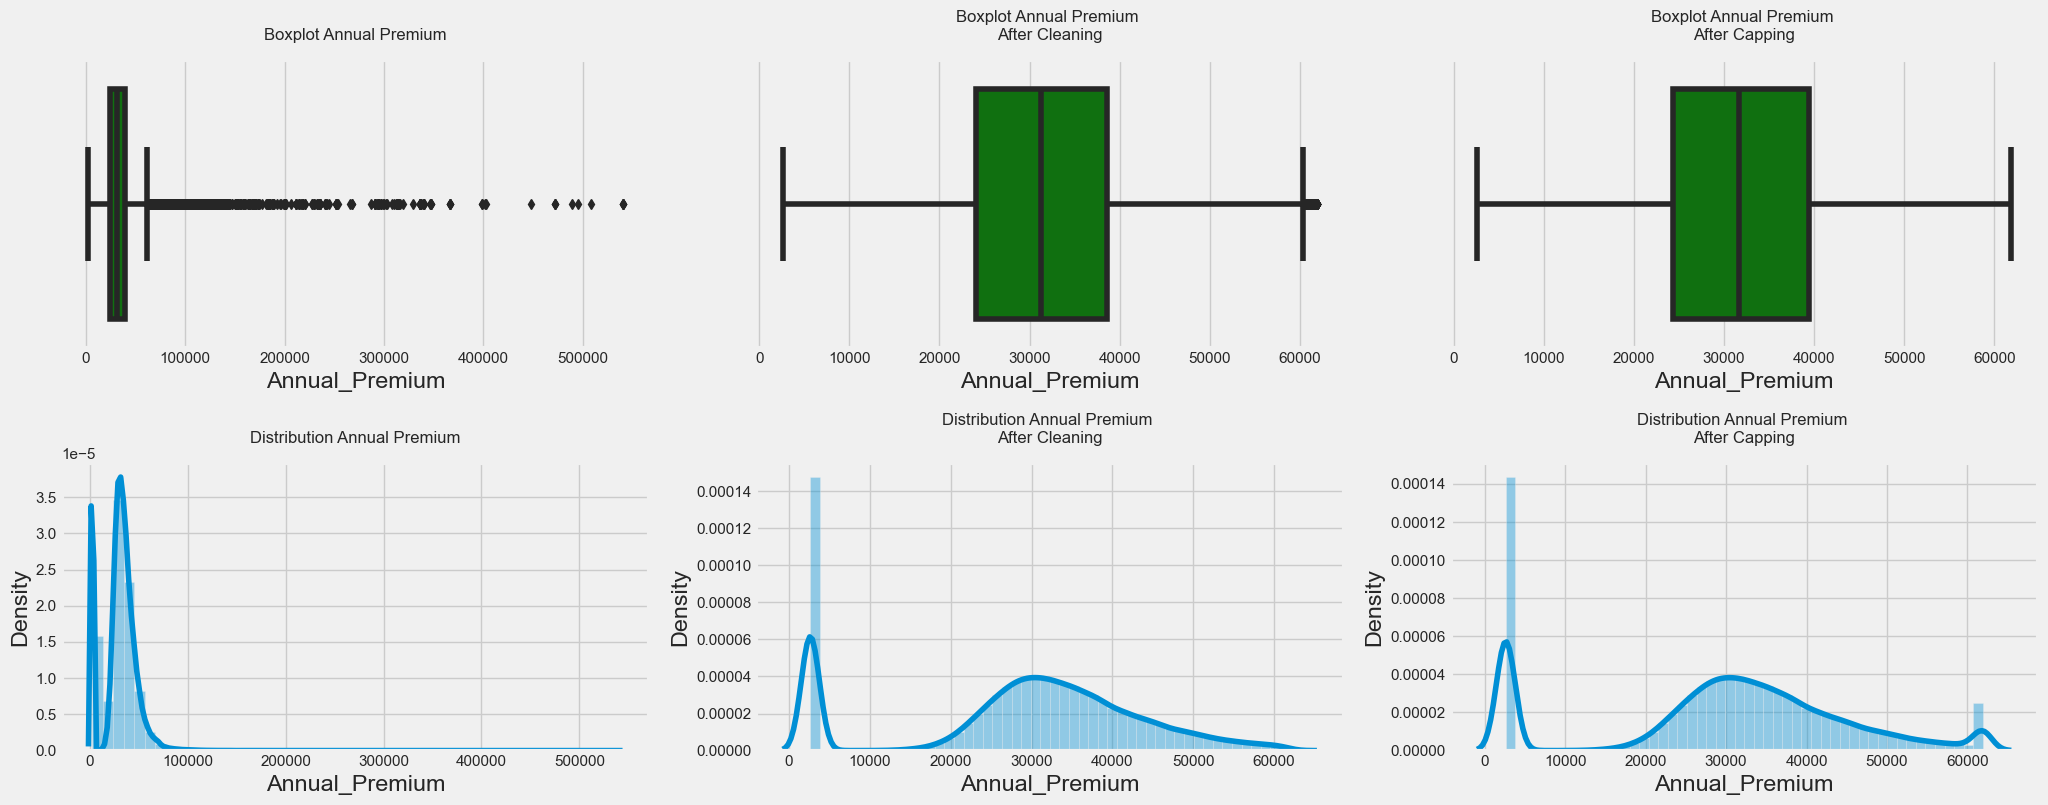

In [16]:
fig, ax = plt.subplots(2,3)

sns.boxplot(x=df['Annual_Premium'], color='green',orient='h',ax=ax[0,0])
ax[0,0].set_title('Boxplot Annual Premium', fontsize=12, pad=15, ha='center')
sns.distplot(df['Annual_Premium'], kde=True,ax=ax[1,0])
ax[1,0].set_title('Distribution Annual Premium', fontsize=12, pad=15, ha='center')

sns.boxplot(x=df_clean['Annual_Premium'], color='green',orient='h',ax=ax[0,1])
ax[0,1].set_title('Boxplot Annual Premium \nAfter Cleaning', fontsize=12, pad=15, ha='center')
sns.distplot(df_clean['Annual_Premium'], kde=True,ax=ax[1,1])
ax[1,1].set_title('Distribution Annual Premium \nAfter Cleaning', fontsize=12, pad=15, ha='center')

sns.boxplot(x=df_cap['Annual_Premium'], color='green',orient='h',ax=ax[0,2])
ax[0,2].set_title('Boxplot Annual Premium \nAfter Capping', fontsize=12, pad=15, ha='center')
sns.distplot(df_cap['Annual_Premium'], kde=True,ax=ax[1,2])
ax[1,2].set_title('Distribution Annual Premium \nAfter Capping', fontsize=12, pad=15, ha='center')

plt.tight_layout()

Diputuskan untuk tetap menggunakan dataframe df karena, kolom `Annual_Premium` merupakan hal yang normal jika terdapat outliers sehingga tidak dilakukan penghapusan outliers. Hal ini juga didasarkan dengan pertimbangan pembuatan model yang robust terhadap outliers.

## Feature encoding

Mengubah `Vehicle_Damage` ke integer dalam = 0: Kendaraan customer belum pernah rusak, 1: Kendaraan customer sudah pernah rusak, serta `Vehicle_Age` dam 0: < 1 Year, 1: 1-2 Years, 2: > 2 Years. Serta `Gender` dengan *One Hot Encoding*. Melakukan konversi ke angka mulai dari 0 untuk memudahkan kerja machine learning. Mengubah kolom dengan datatype bool ke int agar lebih mudah diproses oleh model.

In [5]:
for i in ['Gender']:
    onehots = pd.get_dummies(df['Gender'], prefix='Gen')
    df = df.join(onehots)

df[['Gen_Female','Gen_Male']] = df[['Gen_Female','Gen_Male']].astype(int)

In [6]:
mapping_damage = {'Yes' : 1, 'No' : 0}
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(mapping_damage)


In [7]:
mapping_age = {'> 2 Years' : 2, '1-2 Year' : 1, '< 1 Year' : 0}
df['Vehicle_Age'] = df['Vehicle_Age'].map(mapping_age)

In [8]:
df.sample(2, random_state=42)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gen_Female,Gen_Male
200222,200223,Female,21,1,3.0,1,0,0,20408.0,160.0,72,0,1,0
49766,49767,Male,55,1,15.0,0,1,1,37498.0,26.0,102,0,0,1


## Class Imbalance

In [9]:
# Melihat berapa dejarat ketimpangan pada class

for i in range(len(df['Response'].value_counts())):
    a = round(df['Response'].value_counts()[i]/df.shape[0]*100,2)
    print(f'{a}%')

print('Degree of Imbalance dari data ini termasuk pada Moderate Imbalance')

87.74%
12.26%
Degree of Imbalance dari data ini termasuk pada Moderate Imbalance


Penanganan Class Imbalance dilakukan dengan ***oversampling*** dan ***undersampling*** dengan pertimbangan agar data tidak cenderung bias, dimana selisih antara kedua value 0 dan 1 lebih dari 50% sehingga jika dilakukan *oversampling* tidak menjamin akan adanya peningkatan performansi machine learning, namun dibutuhkan pula oversampling agar data tidak underfit.

In [10]:
# Membuat kolom baru untuk melihat Class 'Yes'

df['Res_class'] = df['Response']==1
df['Res_class'].value_counts()

Res_class
False    334399
True      46710
Name: count, dtype: int64

In [11]:
# Memisahkan dataframe dengan Response dan Res_class dan hanya Res_class
X = df[[col for col in df.columns if (str(df[col].dtype) != 'object') and col not in ['Response', 'Res_class']]]
y = df['Res_class'].values
print(X.shape)
print(y.shape)

(381109, 12)
(381109,)


In [12]:
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE(sampling_strategy=0.3, random_state=42).fit_resample(X, y)

In [13]:
pd.Series(y_over_SMOTE).value_counts()

False    334399
True     100319
Name: count, dtype: int64

In [14]:
X_over_SMOTE['Response'] = y_over_SMOTE.astype(int)
df = X_over_SMOTE.copy()

In [15]:
# Memisahkan dataframe dengan Response dan Res_class dan hanya Res_class
df['Res_class'] = df['Response']==1
df['Res_class'].value_counts()
X2 = df[[col for col in df.columns if (str(df[col].dtype) != 'object') and col not in ['Response', 'Res_class']]]
y2 = df['Res_class'].values
print(X2.shape)
print(y2.shape)

(434718, 12)
(434718,)


In [16]:
X_under, y_under = under_sampling.RandomUnderSampler(sampling_strategy=1, random_state=42).fit_resample(X2, y2)

In [17]:
print('Original')
print(pd.Series(y).value_counts())
print('\n')
print('OVERSAMPLING SMOTE & UNDERSAMPLING')
print('')
print(pd.Series(y_under).value_counts())

Original
False    334399
True      46710
Name: count, dtype: int64


OVERSAMPLING SMOTE & UNDERSAMPLING

False    100319
True     100319
Name: count, dtype: int64


In [18]:
X_under['Response'] = y_under.astype(int)
df = X_under.copy()

# Feature Engineering

## Feature Selection

In [19]:
df.drop(columns=['id'], axis=1, inplace=True)

<Axes: >

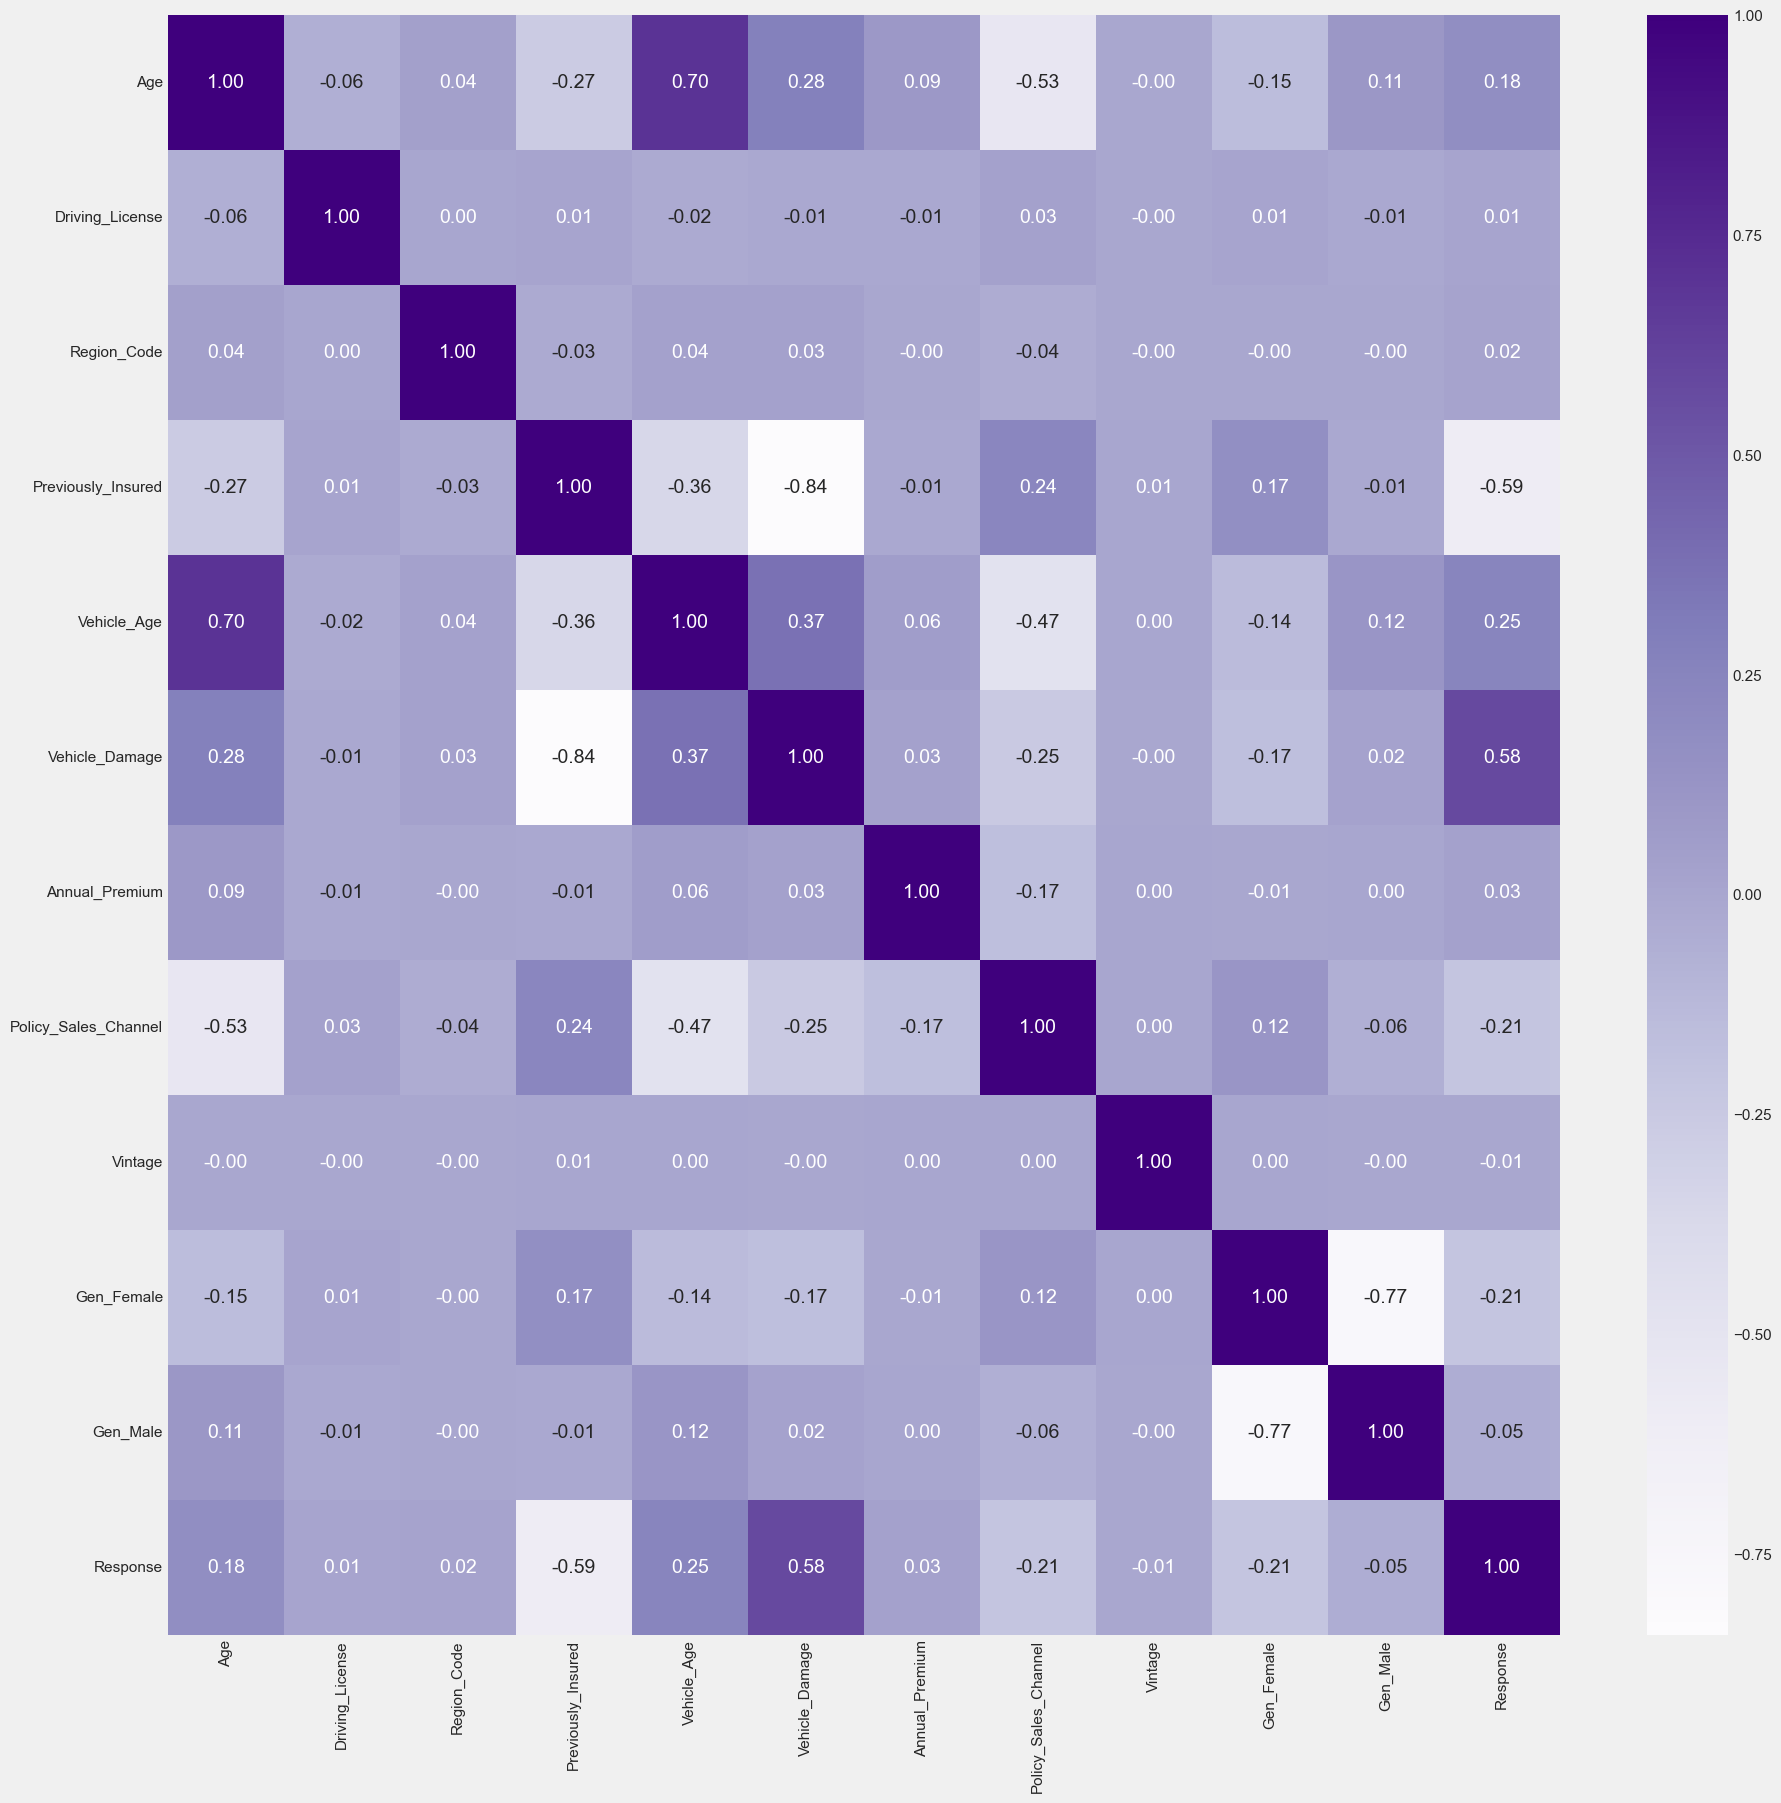

In [20]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='Purples', annot=True, fmt='.2f')

Dari heatmap dapat didapatkan insight bahwa, `Age` dan `Vehicle_Age` merupakan kolom redundant sehingga diputuskan untuk tidak menggunakan pada kolom `Age` dengan pertimbangan kolom `Age` memiliki korelasi lebih kecil dibandingkan `Vehicle_Age`.

## Feature Extraction

In [20]:
# Membuat fitur kategori baru dari Age dengan mengelompokkan YoungAdults 17 - 30, MiddleAged 31-45, OldAdults > 45
Age_Group = []
for i in df['Age']:
    if 17 <= i <=30:
        Age_Group.append(0)
    elif 31 <= i <= 45:
        Age_Group.append(1)
    else:
        Age_Group.append(2)

df['Age_Group'] = Age_Group
df

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gen_Female,Gen_Male,Response,Age_Group
79509,22,1,19.000000,1,0,0,54559.000000,152.000000,87,1,0,0,0
186554,57,1,18.000000,0,1,1,33439.000000,124.000000,63,0,1,0,2
158036,64,1,28.000000,0,1,1,39327.000000,122.000000,45,1,0,0,2
343705,52,1,41.000000,1,1,0,26536.000000,124.000000,161,0,1,0,2
137902,21,1,7.000000,0,0,0,28416.000000,152.000000,92,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434713,59,1,32.622736,0,1,1,39675.071349,67.184377,232,0,1,1,2
434714,23,1,16.460178,0,0,1,37111.150397,147.705007,217,0,0,1,0
434715,63,1,26.720202,0,1,1,46763.984536,61.289917,102,0,1,1,2
434716,46,1,28.000000,0,1,1,31261.324288,90.890096,143,0,1,1,2


In [21]:
# Melakukan ekstrasi dari kolom Annual_Premium dengan LowPremium < 24406, MediumPremium 24406 - 61892.4 dan HighPremium > 61892.4
c = []

for i in df['Annual_Premium']:
    if i <=  24405:
        c.append(0)
    elif 24406 <= i <= 61892.4:
        c.append(1)
    else:
        c.append(2)

df['Premium_cat'] = c
df

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gen_Female,Gen_Male,Response,Age_Group,Premium_cat
79509,22,1,19.000000,1,0,0,54559.000000,152.000000,87,1,0,0,0,1
186554,57,1,18.000000,0,1,1,33439.000000,124.000000,63,0,1,0,2,1
158036,64,1,28.000000,0,1,1,39327.000000,122.000000,45,1,0,0,2,1
343705,52,1,41.000000,1,1,0,26536.000000,124.000000,161,0,1,0,2,1
137902,21,1,7.000000,0,0,0,28416.000000,152.000000,92,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434713,59,1,32.622736,0,1,1,39675.071349,67.184377,232,0,1,1,2,1
434714,23,1,16.460178,0,0,1,37111.150397,147.705007,217,0,0,1,0,1
434715,63,1,26.720202,0,1,1,46763.984536,61.289917,102,0,1,1,2,1
434716,46,1,28.000000,0,1,1,31261.324288,90.890096,143,0,1,1,2,1


In [22]:
# Melakukan ekstrasi kolom Policy_Sales_Channel berdasarkan value_counts
p = df['Policy_Sales_Channel'].value_counts()
Policy_cat = p.apply(lambda x : 3 if x>=16455 else 2 if 8227<x<16455 else 1 if x<=8227 else 0)
Policy_cat = dict(zip(Policy_cat.keys(),Policy_cat.values))
df['Policy_cat'] = df['Policy_Sales_Channel'].map(Policy_cat)
df

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gen_Female,Gen_Male,Response,Age_Group,Premium_cat,Policy_cat
79509,22,1,19.000000,1,0,0,54559.000000,152.000000,87,1,0,0,0,1,3
186554,57,1,18.000000,0,1,1,33439.000000,124.000000,63,0,1,0,2,1,3
158036,64,1,28.000000,0,1,1,39327.000000,122.000000,45,1,0,0,2,1,1
343705,52,1,41.000000,1,1,0,26536.000000,124.000000,161,0,1,0,2,1,3
137902,21,1,7.000000,0,0,0,28416.000000,152.000000,92,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434713,59,1,32.622736,0,1,1,39675.071349,67.184377,232,0,1,1,2,1,1
434714,23,1,16.460178,0,0,1,37111.150397,147.705007,217,0,0,1,0,1,1
434715,63,1,26.720202,0,1,1,46763.984536,61.289917,102,0,1,1,2,1,1
434716,46,1,28.000000,0,1,1,31261.324288,90.890096,143,0,1,1,2,1,1


In [23]:
# Melakukan ekstrasi kolom Region_Code berdasarkan value_counts
r = df['Region_Code'].value_counts()
Region_cat = r.apply(lambda x : 2 if x > 8339 else 1 if 2611<=x<=8339 else 0)
Region_cat = dict(zip(Region_cat.keys(),Region_cat.values))
df['Region_cat'] = df['Region_Code'].map(Region_cat)
df

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gen_Female,Gen_Male,Response,Age_Group,Premium_cat,Policy_cat,Region_cat
79509,22,1,19.000000,1,0,0,54559.000000,152.000000,87,1,0,0,0,1,3,0
186554,57,1,18.000000,0,1,1,33439.000000,124.000000,63,0,1,0,2,1,3,0
158036,64,1,28.000000,0,1,1,39327.000000,122.000000,45,1,0,0,2,1,1,2
343705,52,1,41.000000,1,1,0,26536.000000,124.000000,161,0,1,0,2,1,3,1
137902,21,1,7.000000,0,0,0,28416.000000,152.000000,92,1,0,0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434713,59,1,32.622736,0,1,1,39675.071349,67.184377,232,0,1,1,2,1,1,0
434714,23,1,16.460178,0,0,1,37111.150397,147.705007,217,0,0,1,0,1,1,0
434715,63,1,26.720202,0,1,1,46763.984536,61.289917,102,0,1,1,2,1,1,0
434716,46,1,28.000000,0,1,1,31261.324288,90.890096,143,0,1,1,2,1,1,2


<Axes: >

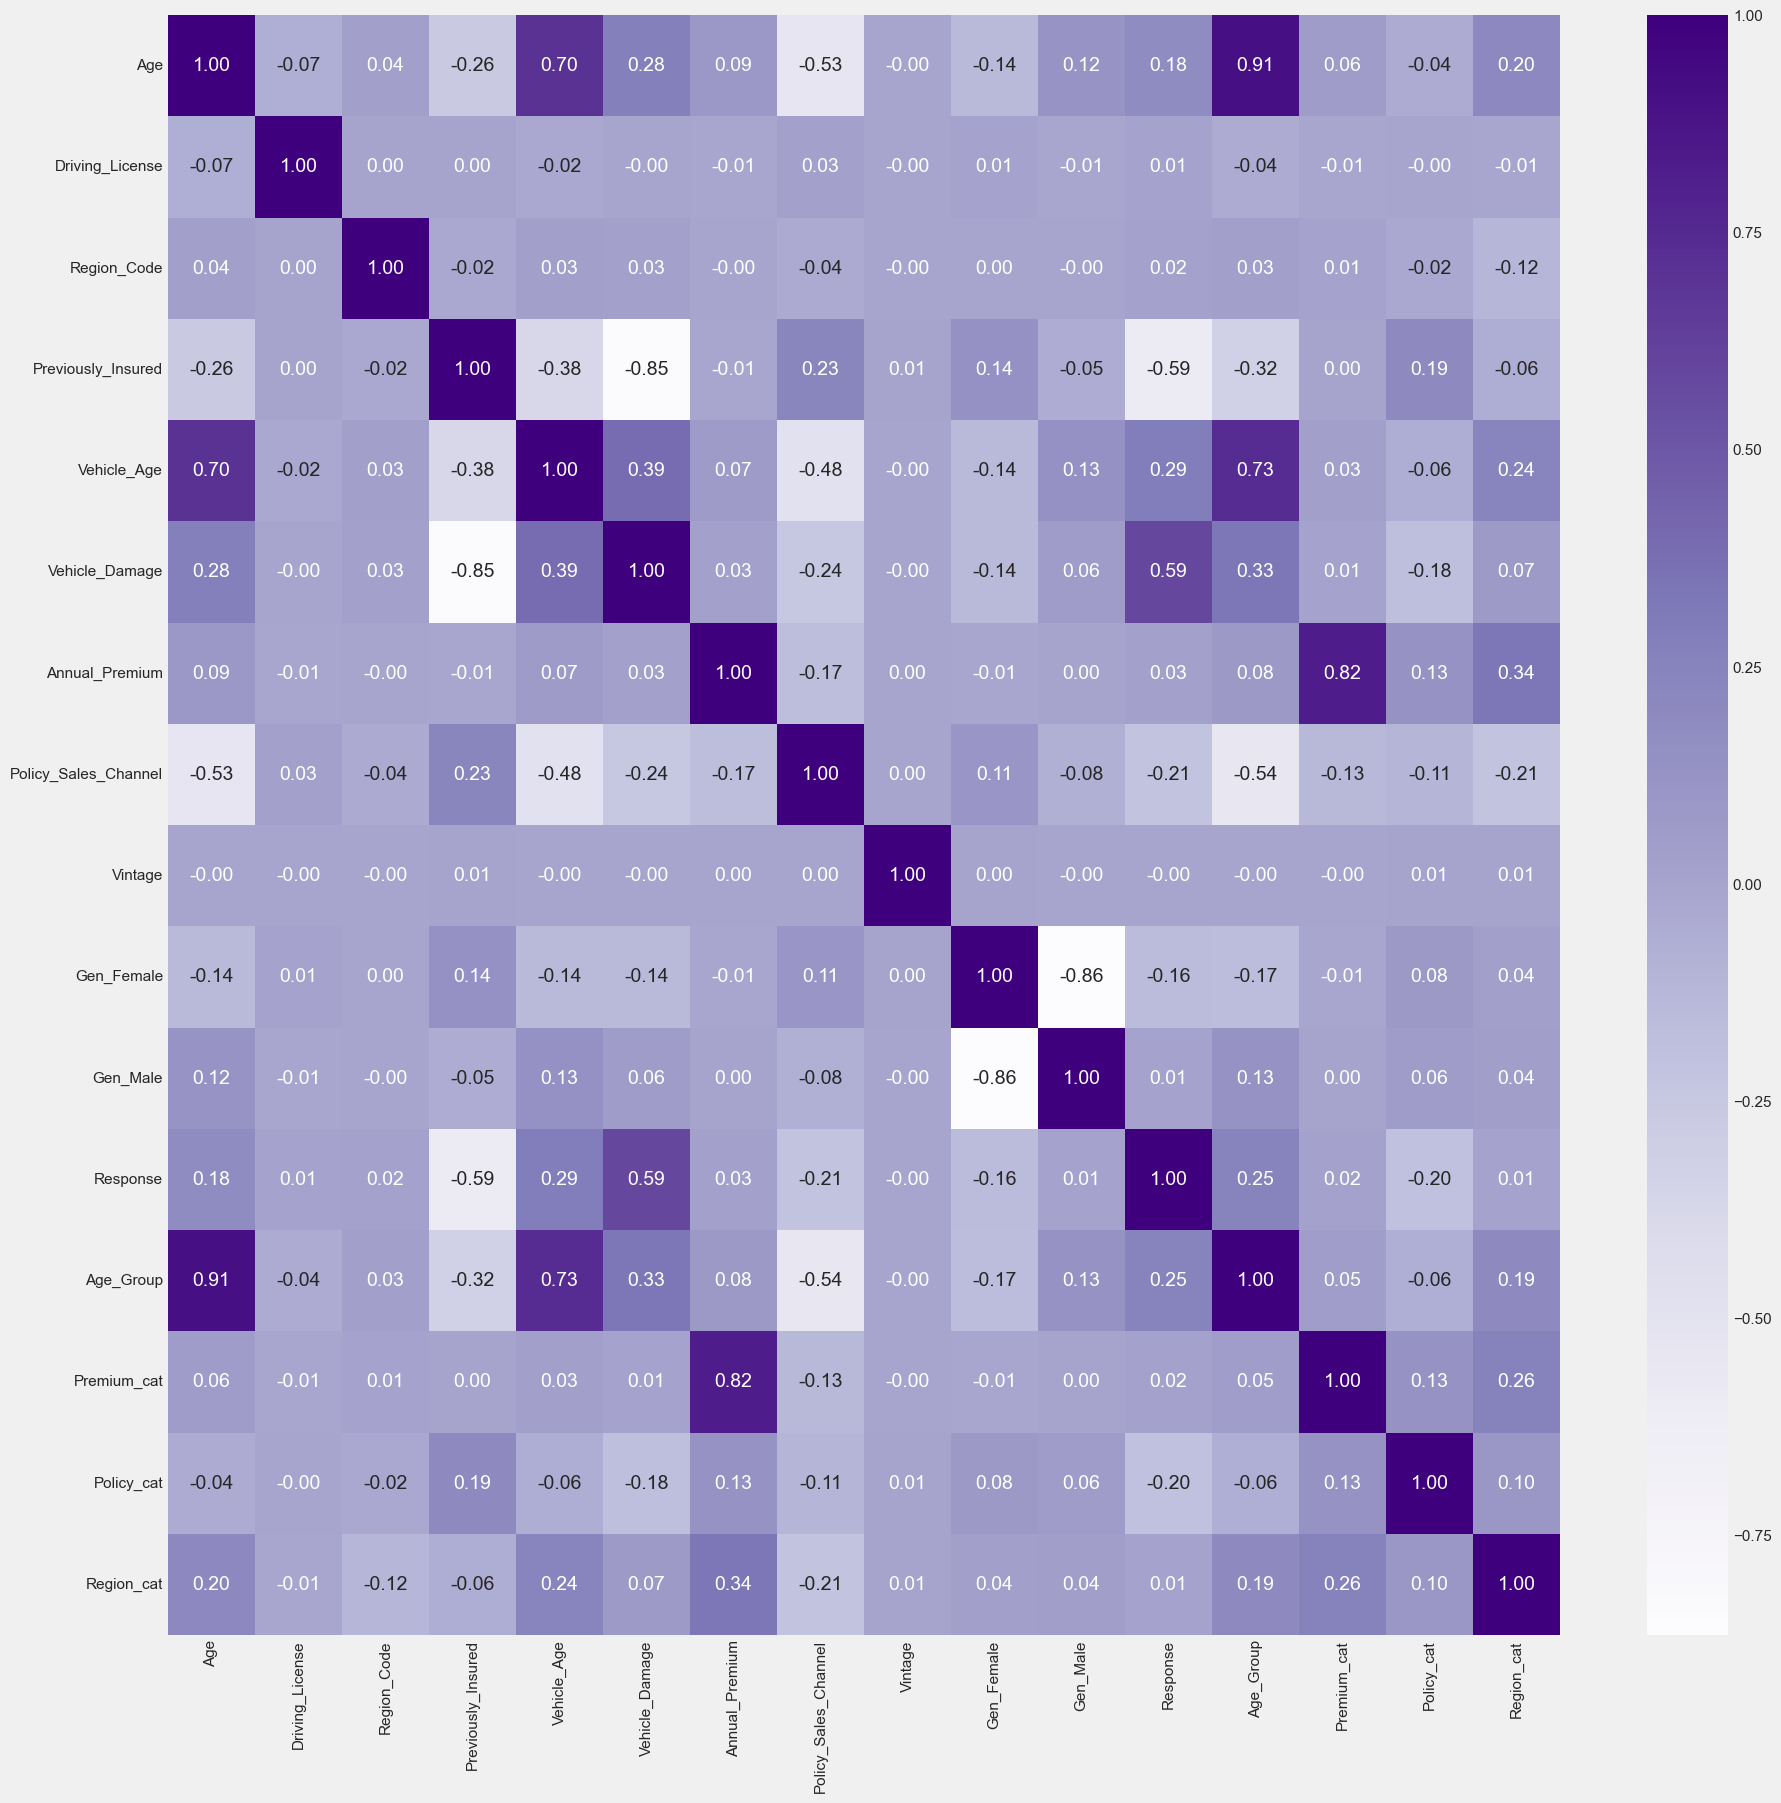

In [63]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='Purples', annot=True, fmt='.2f')

Dari hasil *feature extraction* didapatkan insight bahwa `Policy_cat` tidak memiliki korelasi dengan `Response`, sedangkan `Age_Group` dan `Premium_cat` memiliki korelasi *positive*.

## 4 New Features

1. `Premium_Per_Channel`, untuk menghitung dan memberi insight baru mengenai total premium dari berbagai `Policy_Sales_Channel` dengan begitu pengelompokkan Channel dapat dilakukan berdasarkan `Annual_Premium`.

2. `Vintage_Group`, feature baru yang mengubah feature `Vintage` menjadi kategori dengan range tertentu dimana diartikan menjadi New (baru bergabung), Intermediate (sudah bergabung cukup lama), Long-term (sudah bergabung lama).

3. `Not_Insured_and_Damaged`, kolom yang berisikan nilai 1 jika kolom `Previously_Insured` memiliki value 0 dan `Vehicle_Damage` memiliki value 1.

4. `Channel_Response_Rate`, merupakan rate respon dari tiap channel dimana menindikasikan seberapa efektif suatu channel untuk mendapatkan jawaban 'Yes' dari sini juga dapat dilakukan pengelompokkan Channels yang memiliki rate tinggi.

## Feature Transformation

Data memiliki karakteristik mayoritas sudah berbentuk Gaussian namun ada beberapa yang masih belum tersebar normal.

In [24]:
# Mengkelompokkan kolom-kolom yang akan menjadi features serta target
x = ['int64', 'int32', 'int16', 'float64', 'float32', 'float16']
x = df.select_dtypes(include=x)
x.drop(columns=['Response'],inplace=True)
y = df['Response']

In [25]:
# Melakukan split test and train
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=1/3, random_state=42)

# Menggabungkan kembali features dan target untuk membuat dataframe test dan train

df_train = Xtrain.join(ytrain)
df_test  = Xtest.join(ytest)

Dari seluruh kolom yang bukan merupakan kolom kategori adalah `Age`, `Annual_Premium` dan `Vintage` sehingga hanya ketiga kolom ini yang dilakukan transformasi.

In [26]:
f_log = ['Age']
for i in f_log:
    df_train['log_'+i] = np.log(df_train[i] + (df_train[df_train[i] > 0][i].min() / 2))
    df_test['log_'+i] = np.log(df_test[i] + (df_test[df_test[i] > 0][i].min() / 2))

In [27]:
sscale = ['Annual_Premium','Vintage']
scaler = StandardScaler()
for i in sscale:
    scaler.fit(df_train[[i]])
    scaler.fit(df_test[[i]])
    df_train['std_'+i] = scaler.transform(df_train[[i]])
    df_test['std_'+i] = scaler.transform(df_test[[i]])

In [28]:
sscale = ['Annual_Premium','Vintage']
for i in sscale:
    df_train['box_'+i],_ = boxcox(df_train[i]+1)
    df_test['box_'+i],_ = boxcox(df_test[i]+1)

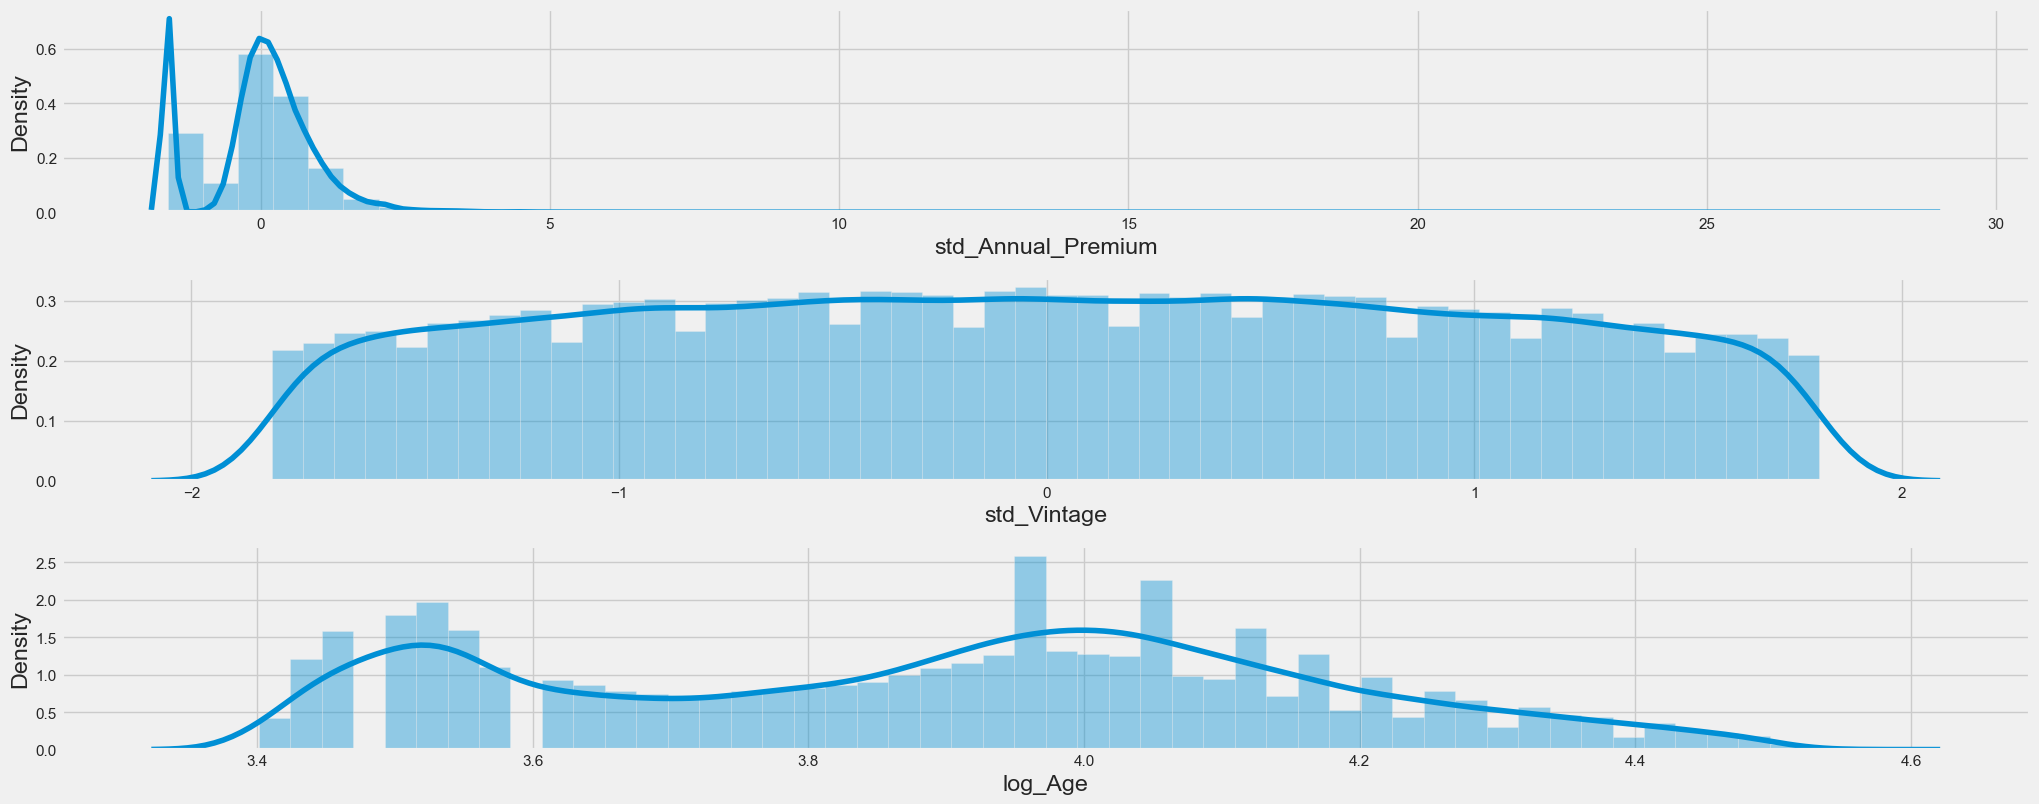

In [31]:
nums_std = ['std_Annual_Premium', 'std_Vintage', 'log_Age']

k = int((len(nums_std)+1)/3)

for i in range(0, len(nums_std)):
    plt.subplot(3, k, i+1)
    sns.distplot(df_train[nums_std[i]], kde=True)
    plt.tight_layout()

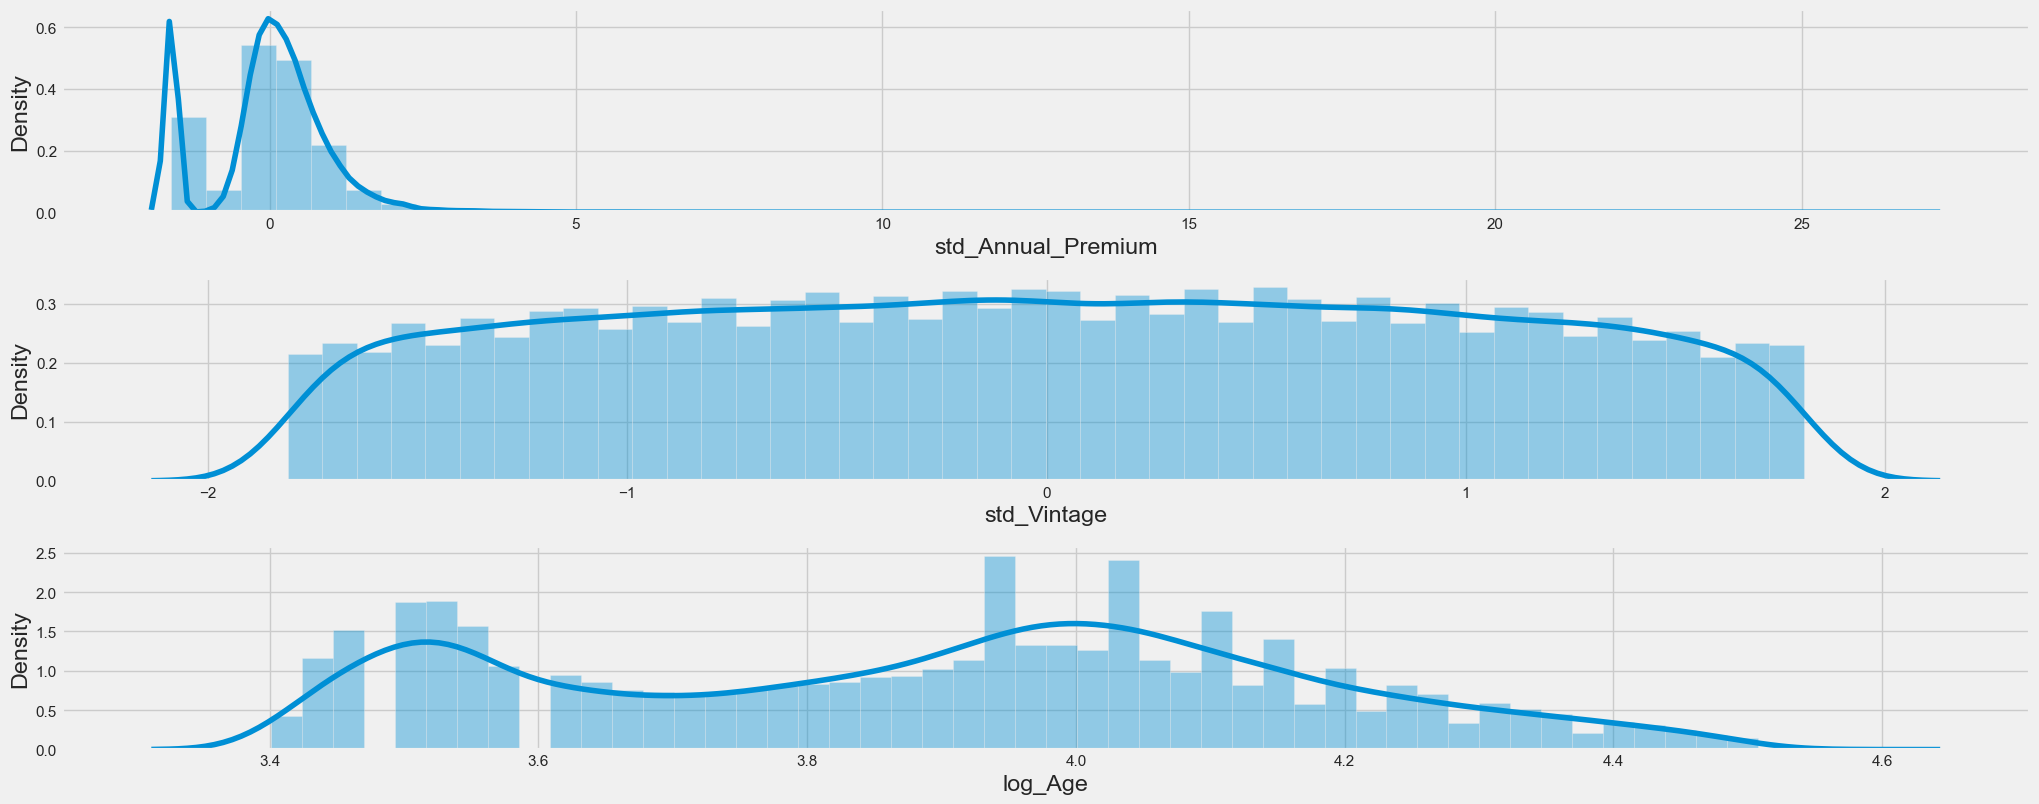

In [29]:
nums_std = ['std_Annual_Premium', 'std_Vintage', 'log_Age']

k = int((len(nums_std)+1)/3)

for i in range(0, len(nums_std)):
    plt.subplot(3, k, i+1)
    sns.distplot(df_test[nums_std[i]], kde=True)
    plt.tight_layout()

<Axes: >

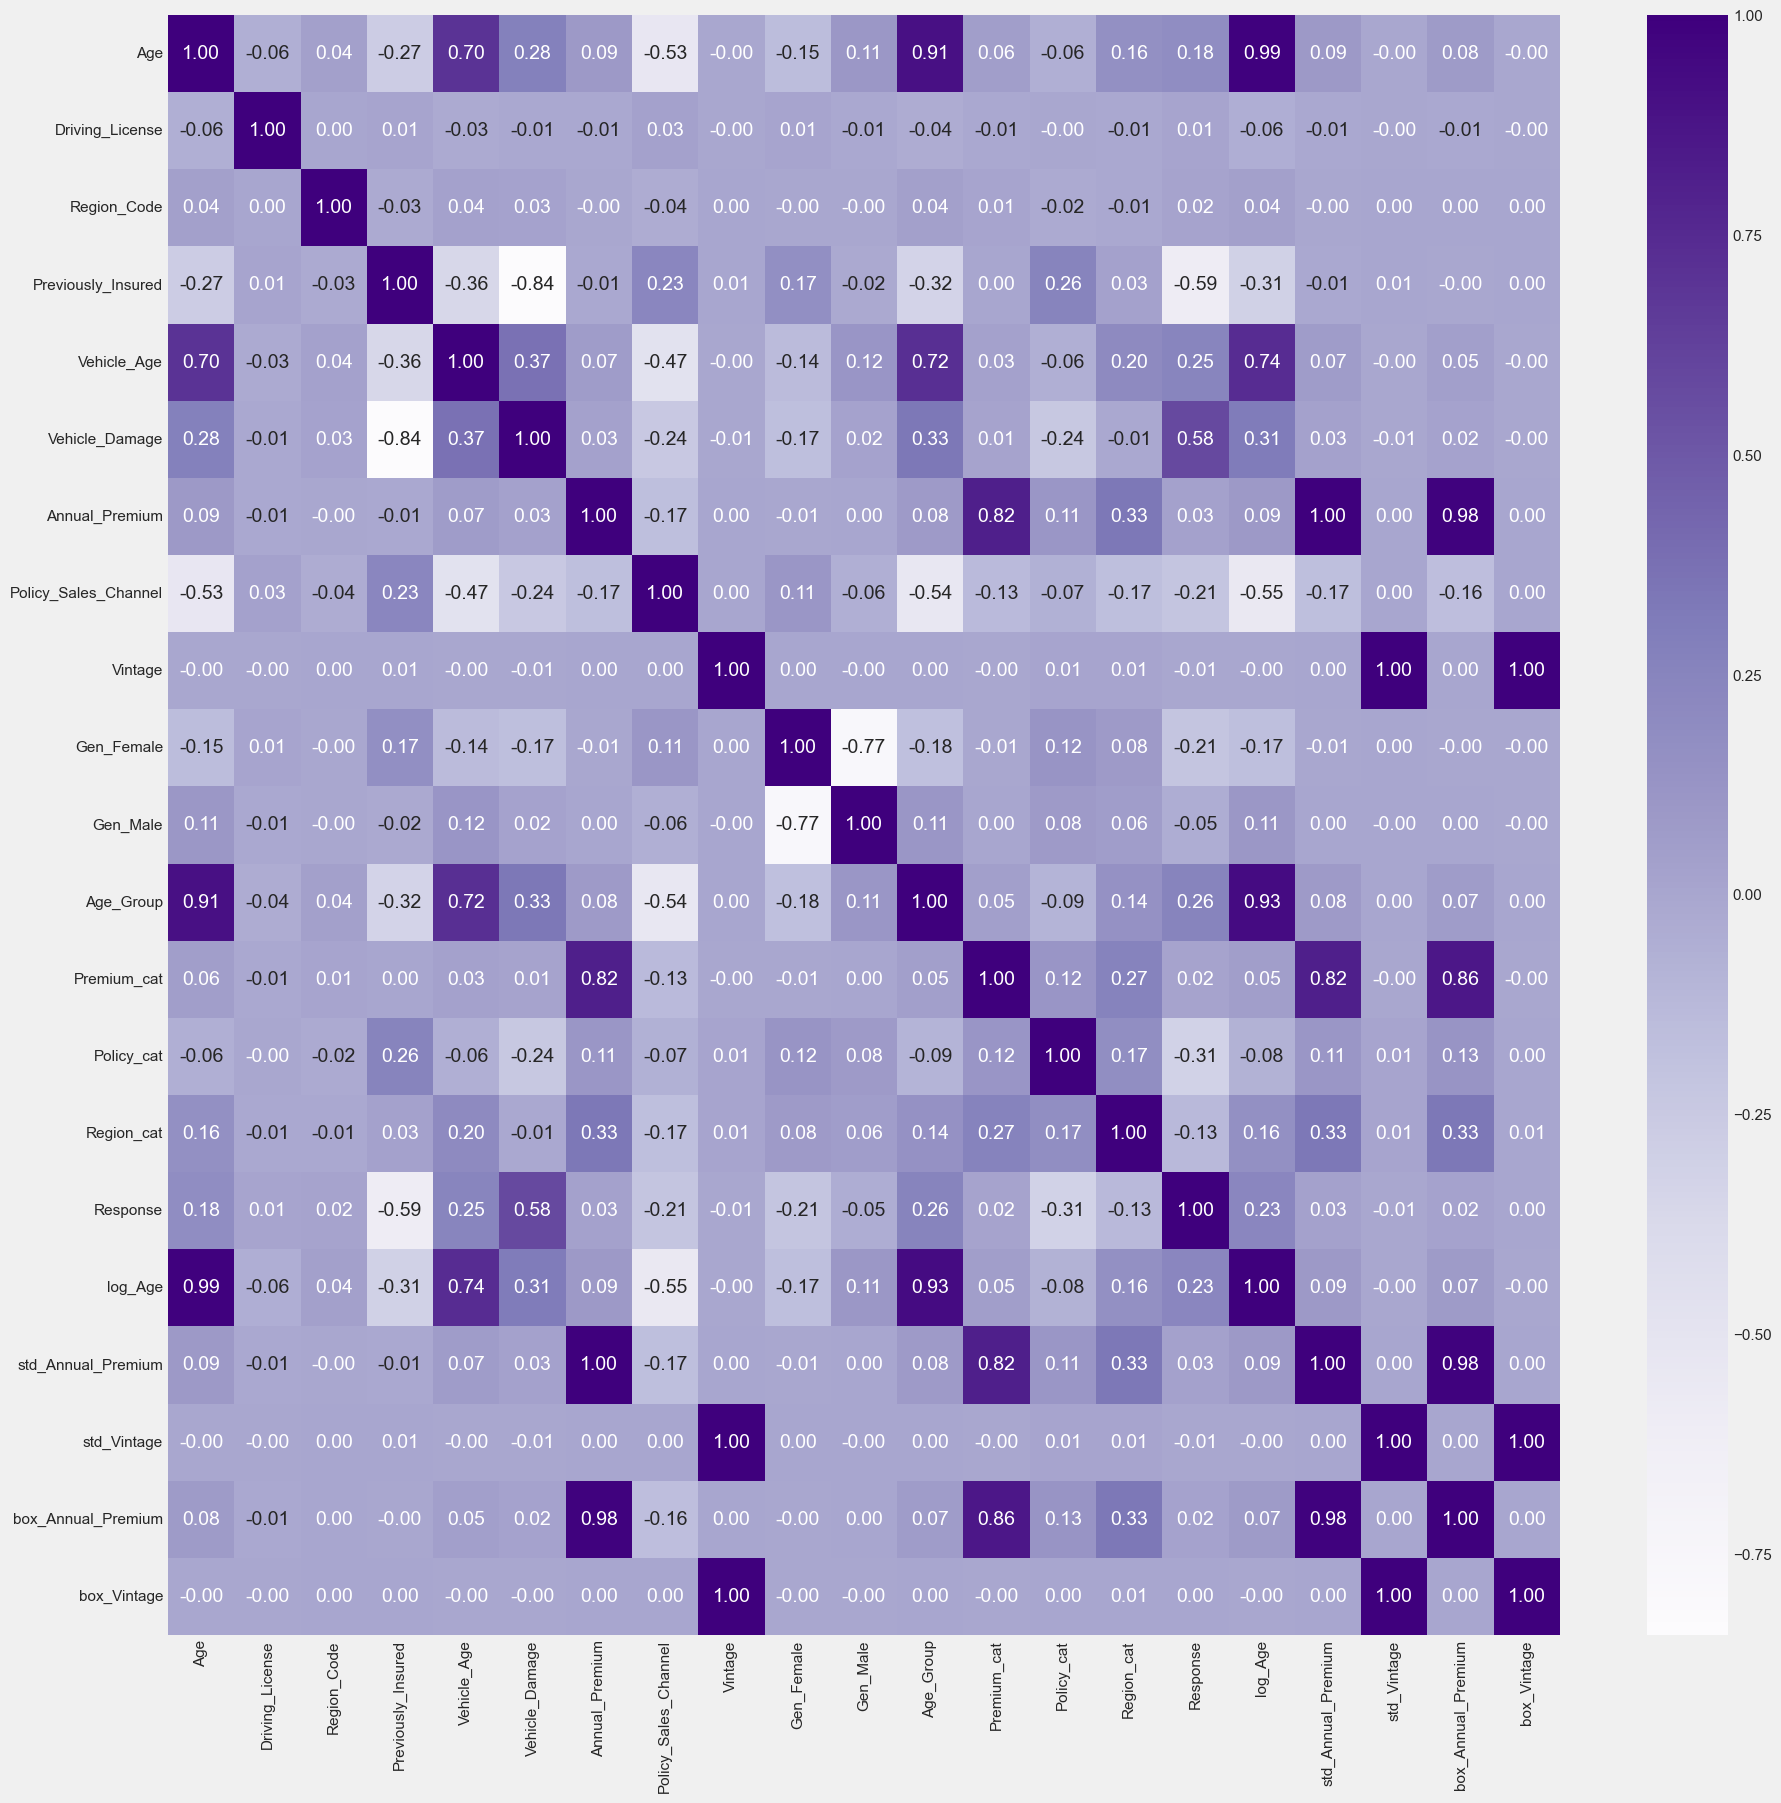

In [32]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_train.corr(), cmap='Purples', annot=True, fmt='.2f')

Diputuskan menggunakan `standardscaler`.

Features yang dipilih `Vehicle_Age`, `Vehicle_Damage`, `Previously_Insured`, `Gen_Female`, `Gen_Male`, `Age_Group`, `Region_cat`, `std_Annual_Premium`.

Sedangkan targetnya adalah `Response`.

# Modelling

In [30]:
df = pd.concat([df_train, df_test])

In [31]:
features = ['Vehicle_Age','Vehicle_Damage','Previously_Insured','Gen_Female','Gen_Male','Age_Group','Region_cat','std_Annual_Premium']
target = ['Response']

Setelah dilakukan modelling pada *features* `Vehicle_Age`,`Vehicle_Damage`,`Previously_Insured`,`Gen_Female`,`Gen_Male`,`Age_Group`,`Region_cat`,`std_Annual_Premium` menggunakan algoritma `Logistic Regression`, `K-Nearest Neighbor`, `Decision Tree`, `XGBoost`, `Random Forest`, `LightGBM`, `Gradient Boost` didapatkan hasil bahwa model-model *overfitting*,

|Model|Accuracy Test|Accuracy Train|Precision Test|Precision Train|Recall Test|Recall Train|F1 Test|F1 Train|ROC AUC Test|ROC AUC Train|ROC AUC CrossVal Test|ROC AUC CrossVal Train|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Logistic|0.79|0.78|0.71|0.71|0.98|0.98|0.82|0.82|0.82|0.82|0.99|0.80|
|KNN|0.76|0.81|0.72|0.77|0.82|0.88|0.77|0.82|0.81|0.89|0.99|0.80|
|Decision Tree|0.72|0.95|0.71|0.93|0.75|0.97|0.73|0.95|0.73|0.99|0.99|0.80|
|XGBoost|0.79|0.80|0.72|0.73|0.93|0.94|0.81|0.82|0.83|0.87|0.99|0.80|
|Random Forest|0.73|0.95|0.71|0.92|0.76|0.98|0.73|0.95|0.81|0.99|0.99|0.80|
|LightGBM|0.79|0.79|0.72|0.73|0.93|0.94|0.81|0.82|0.84|0.85|0.99|0.80|
|Gradient Boost|0.79|0.79|0.72|0.72|0.93|0.94|0.82|0.82|0.84|0.84|0.99|0.80|


Sehingga diputuskan untuk melakukan regularization dan hyperparameter tuning lain namun model masih overfitting maka dipertimbangkan untuk melakukan features selection ulang dan penambahan data.

In [32]:
# New Feature Selection
features_new = ['Vehicle_Age','Vehicle_Damage','Previously_Insured','Age_Group','Region_cat','Policy_Sales_Channel','Gen_Female','Gen_Male']
target_new = ['Response']

X = df[features_new].copy()
y = df[target_new].copy()
X_train = df_train[features_new].copy()
y_train = df_train[target_new].copy()
X_test = df_test[features_new].copy()
y_test = df_test[target_new].copy()

In [33]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    
    score = cross_validate(RandomForestClassifier(), X, y, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (crossval train): '+ str(score['train_score'].mean()))
    print('roc_auc (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

lg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
grd = GradientBoostingClassifier(random_state=42)

### 1. Logistic Regression

In [183]:
lgmodel = lg.fit(X_train, y_train)
eval_classification(lgmodel)

Accuracy (Test Set): 0.79
Accuracy (Train Set): 0.79
Precision (Test Set): 0.72
Precision (Train Set): 0.72
Recall (Test Set): 0.93
Recall (Train Set): 0.94
F1-Score (Test Set): 0.82
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.87
roc_auc (train-proba): 0.87
roc_auc (crossval train): 0.9250789263355971
roc_auc (crossval test): 0.9157560080255982


In [184]:
y_pred_lg_prob = lgmodel.predict_proba(X_test)[:,1]
y_pred_lg = lgmodel.predict(X_test)

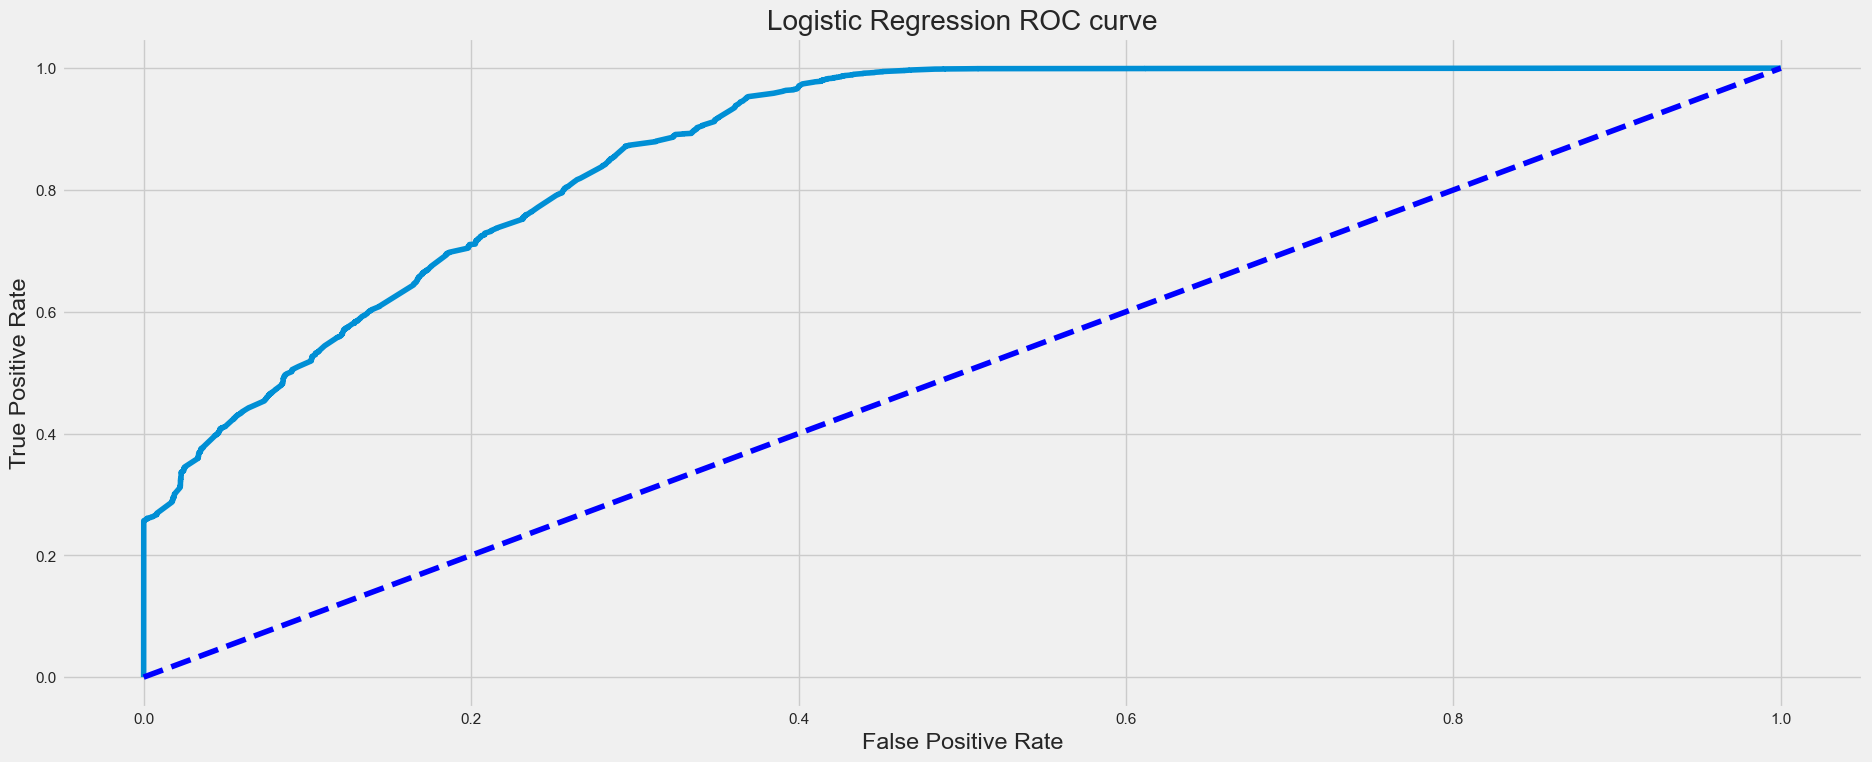

In [185]:
falposr, truposr, _ = roc_curve(y_test, y_pred_lg_prob)
plt.title('Logistic Regression ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[21273 11975]
 [ 2222 31410]]



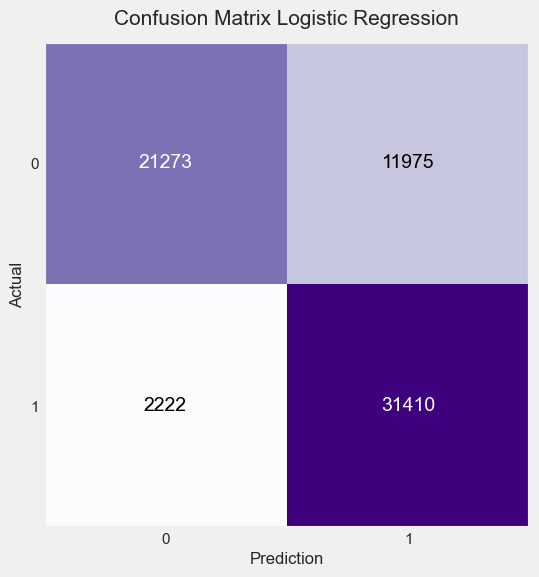

In [186]:
cmlg = confusion_matrix(y_test, y_pred_lg)
print(cmlg)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmlg, figsize=(6, 6), cmap=plt.cm.Purples)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Logistic Regression', fontsize=15, pad=12)
plt.show()

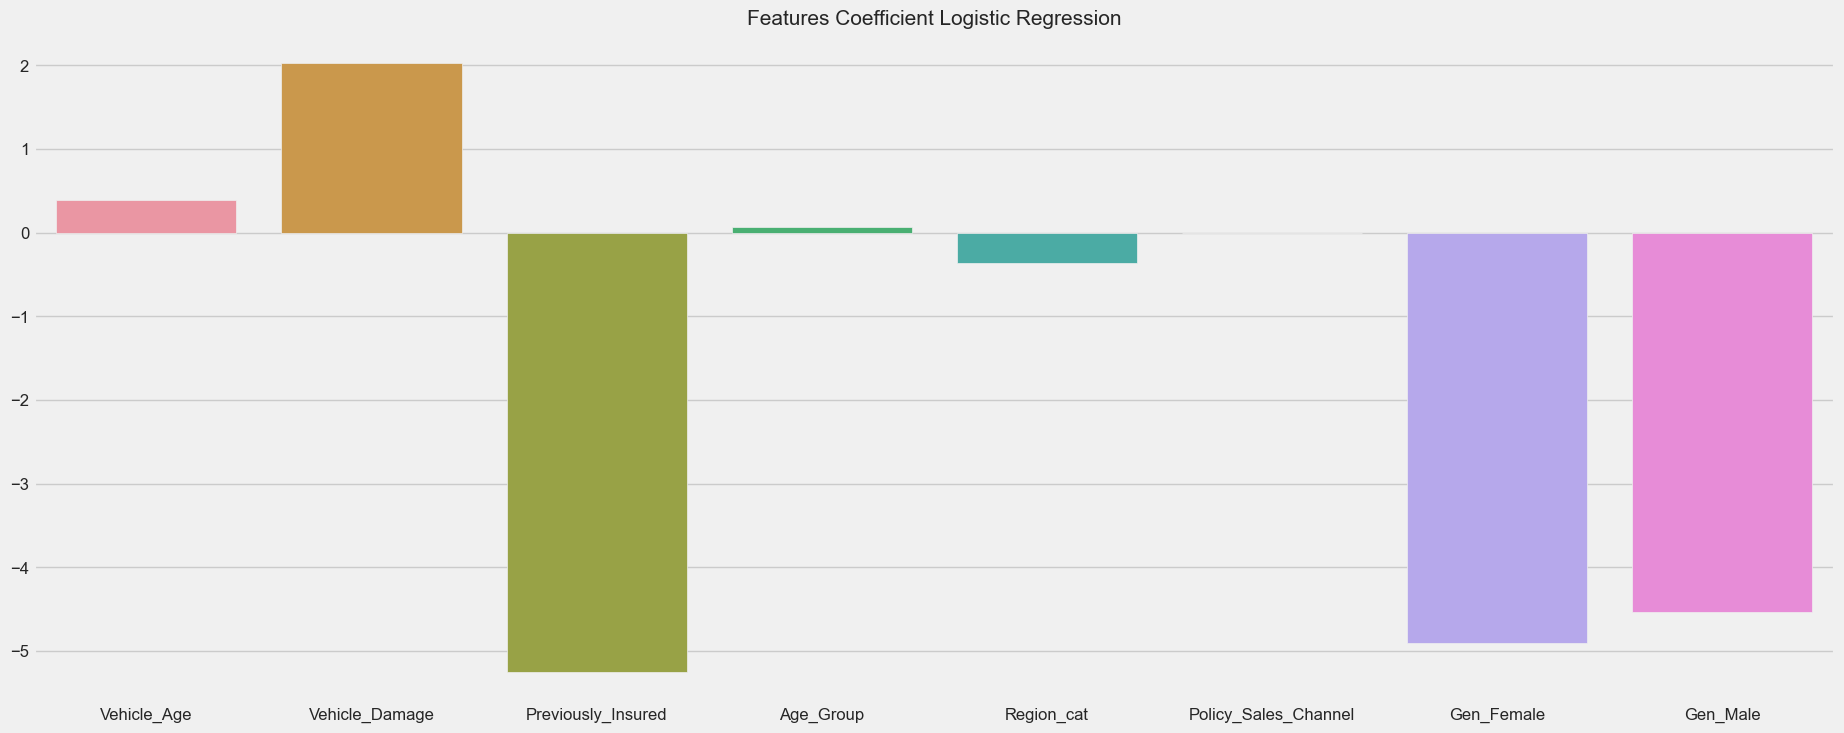

In [187]:
fi = pd.Series(lgmodel.coef_[0], index=df[features_new].columns)
sns.barplot(x=fi.index, y=fi.values)
plt.title('Features Coefficient Logistic Regression', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 2. K-Nearest Neighbor

In [188]:
knnmodel = knn.fit(X_train, y_train)
eval_classification(knnmodel)

Accuracy (Test Set): 0.79
Accuracy (Train Set): 0.80
Precision (Test Set): 0.78
Precision (Train Set): 0.78
Recall (Test Set): 0.83
Recall (Train Set): 0.83
F1-Score (Test Set): 0.80
F1-Score (Train Set): 0.80
roc_auc (test-proba): 0.89
roc_auc (train-proba): 0.89
roc_auc (crossval train): 0.925079255076508
roc_auc (crossval test): 0.9157789661955439


In [189]:
y_pred_knn_prob = knnmodel.predict_proba(X_test)[:,1]
y_pred_knn = knnmodel.predict(X_test)

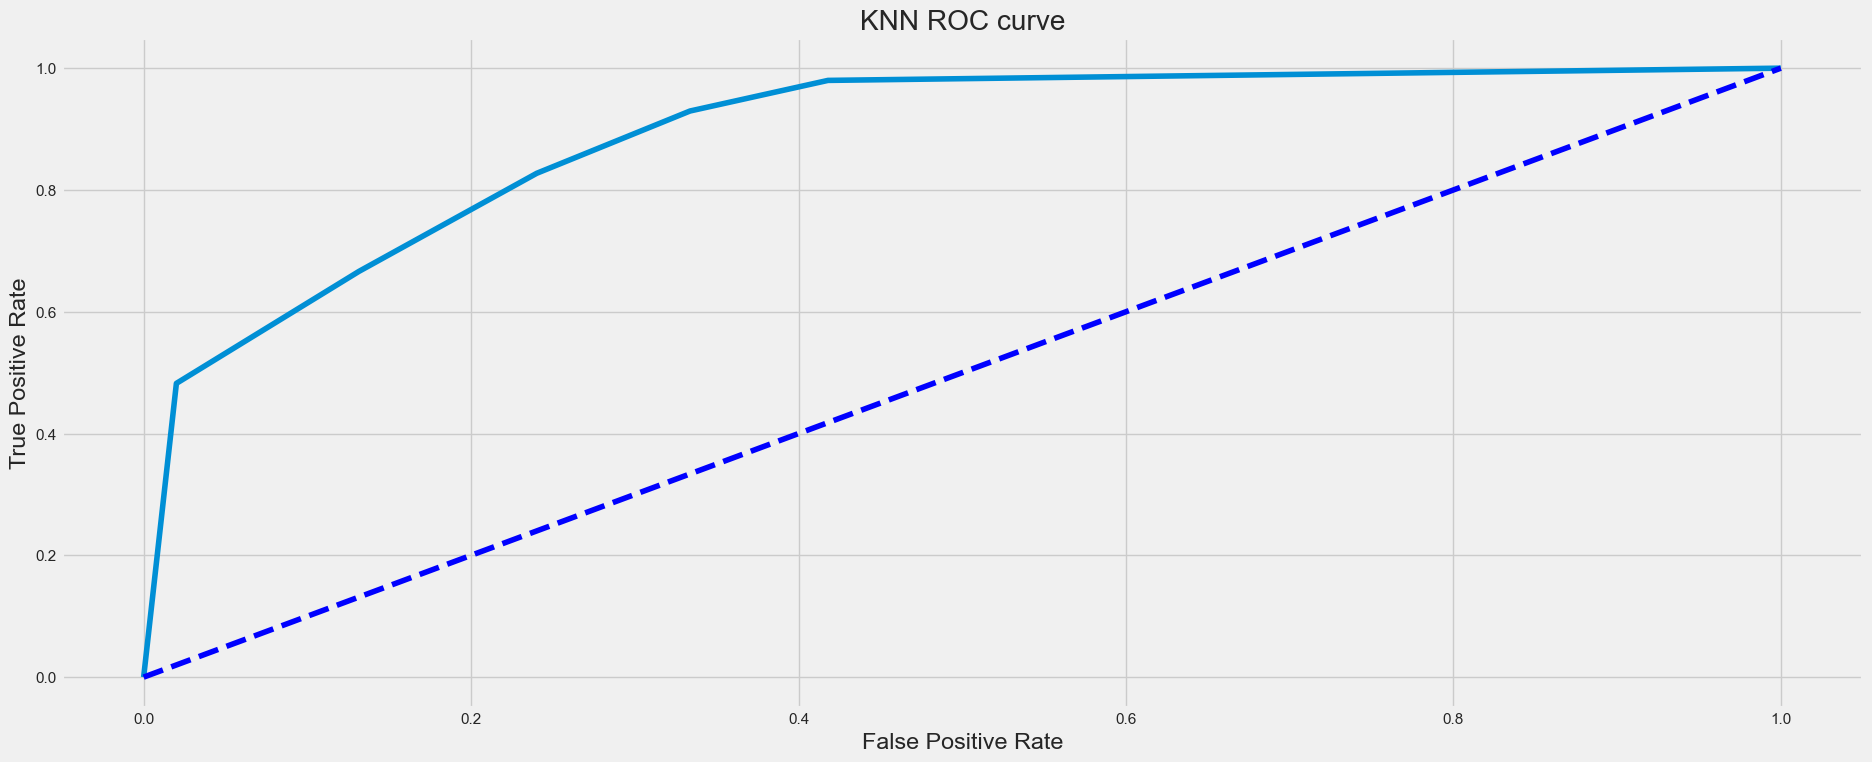

In [190]:
falposr, truposr, _ = roc_curve(y_test, y_pred_knn_prob)
plt.title('KNN ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[25265  7983]
 [ 5806 27826]]



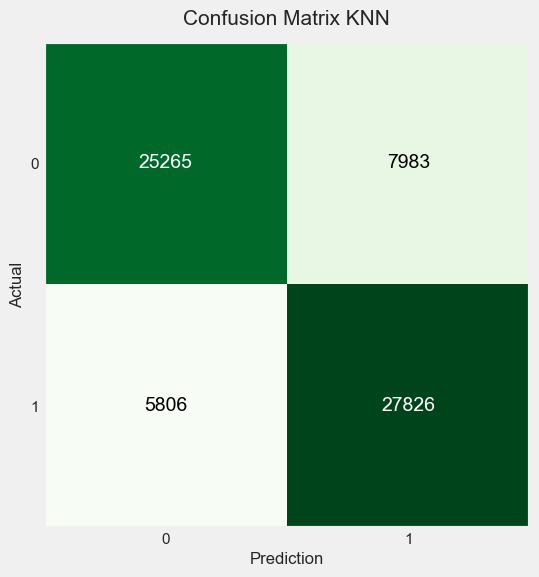

In [191]:
cmknn = confusion_matrix(y_test, y_pred_knn)
print(cmknn)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmknn, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix KNN', fontsize=15, pad=12)
plt.show()

### 3. Decision Tree

In [192]:
dtmodel = dt.fit(X_train, y_train)
eval_classification(dtmodel)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.83
Precision (Test Set): 0.78
Precision (Train Set): 0.79
Recall (Test Set): 0.89
Recall (Train Set): 0.90
F1-Score (Test Set): 0.83
F1-Score (Train Set): 0.84
roc_auc (test-proba): 0.91
roc_auc (train-proba): 0.93
roc_auc (crossval train): 0.925083761731055
roc_auc (crossval test): 0.9158048788007352


In [193]:
y_pred_dt_prob = dtmodel.predict_proba(X_test)[:,1]
y_pred_dt = dtmodel.predict(X_test)

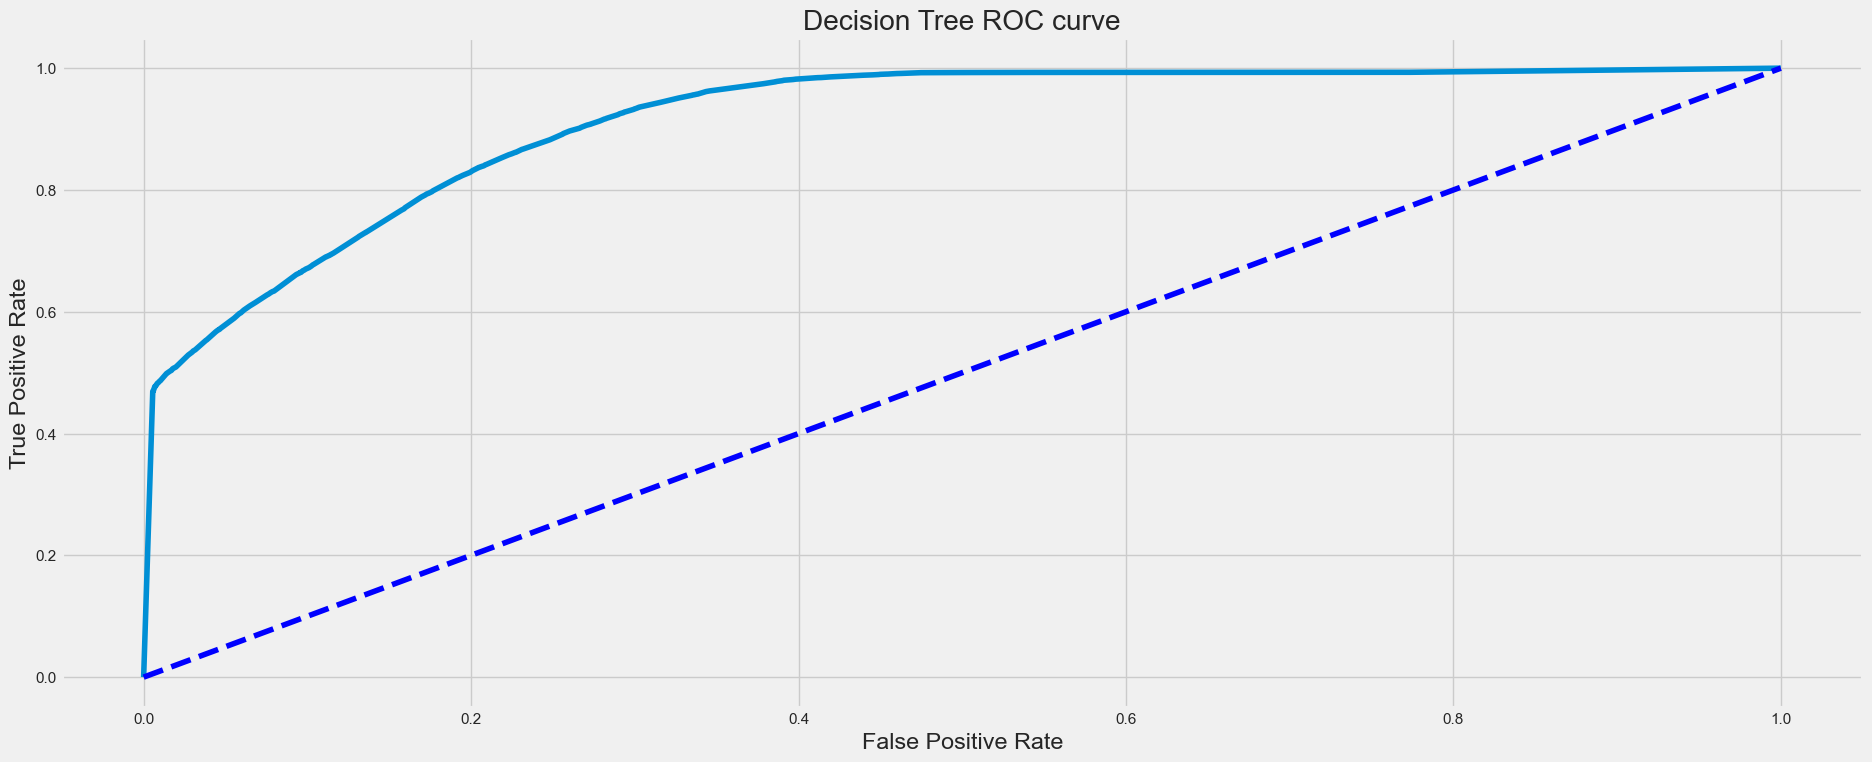

In [194]:
falposr, truposr, _ = roc_curve(y_test, y_pred_dt_prob)
plt.title('Decision Tree ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[24728  8520]
 [ 3615 30017]]



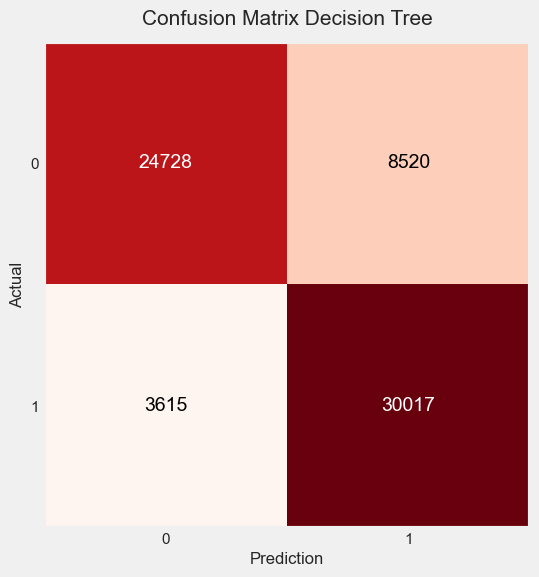

In [195]:
cmdt = confusion_matrix(y_test, y_pred_dt)
print(cmdt)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmdt, figsize=(6, 6), cmap=plt.cm.Reds)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Decision Tree', fontsize=15, pad=12)
plt.show()

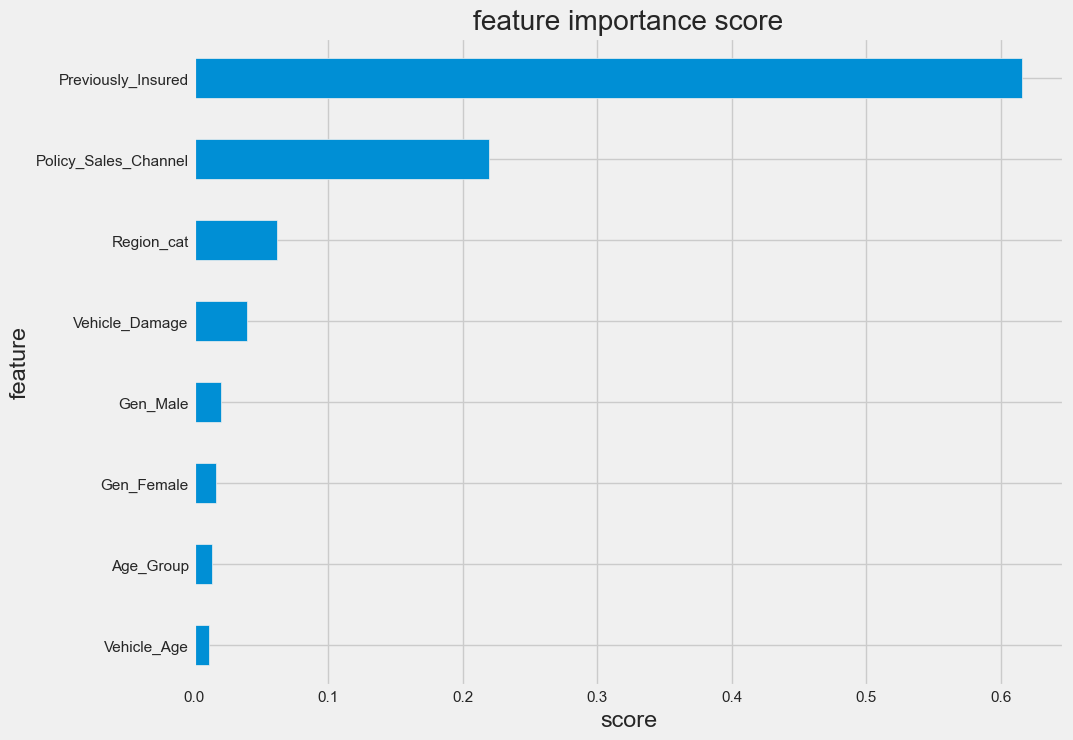

In [196]:
show_feature_importance(dtmodel)

### 4. XGBoost

In [197]:
xgmodel = xgb.fit(X_train, y_train)
eval_classification(xgmodel)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.83
Precision (Test Set): 0.78
Precision (Train Set): 0.78
Recall (Test Set): 0.91
Recall (Train Set): 0.91
F1-Score (Test Set): 0.84
F1-Score (Train Set): 0.84
roc_auc (test-proba): 0.92
roc_auc (train-proba): 0.92
roc_auc (crossval train): 0.9250786602298973
roc_auc (crossval test): 0.9158249150379346


In [198]:
y_pred_xg_prob = xgmodel.predict_proba(X_test)[:,1]
y_pred_xg = xgmodel.predict(X_test)

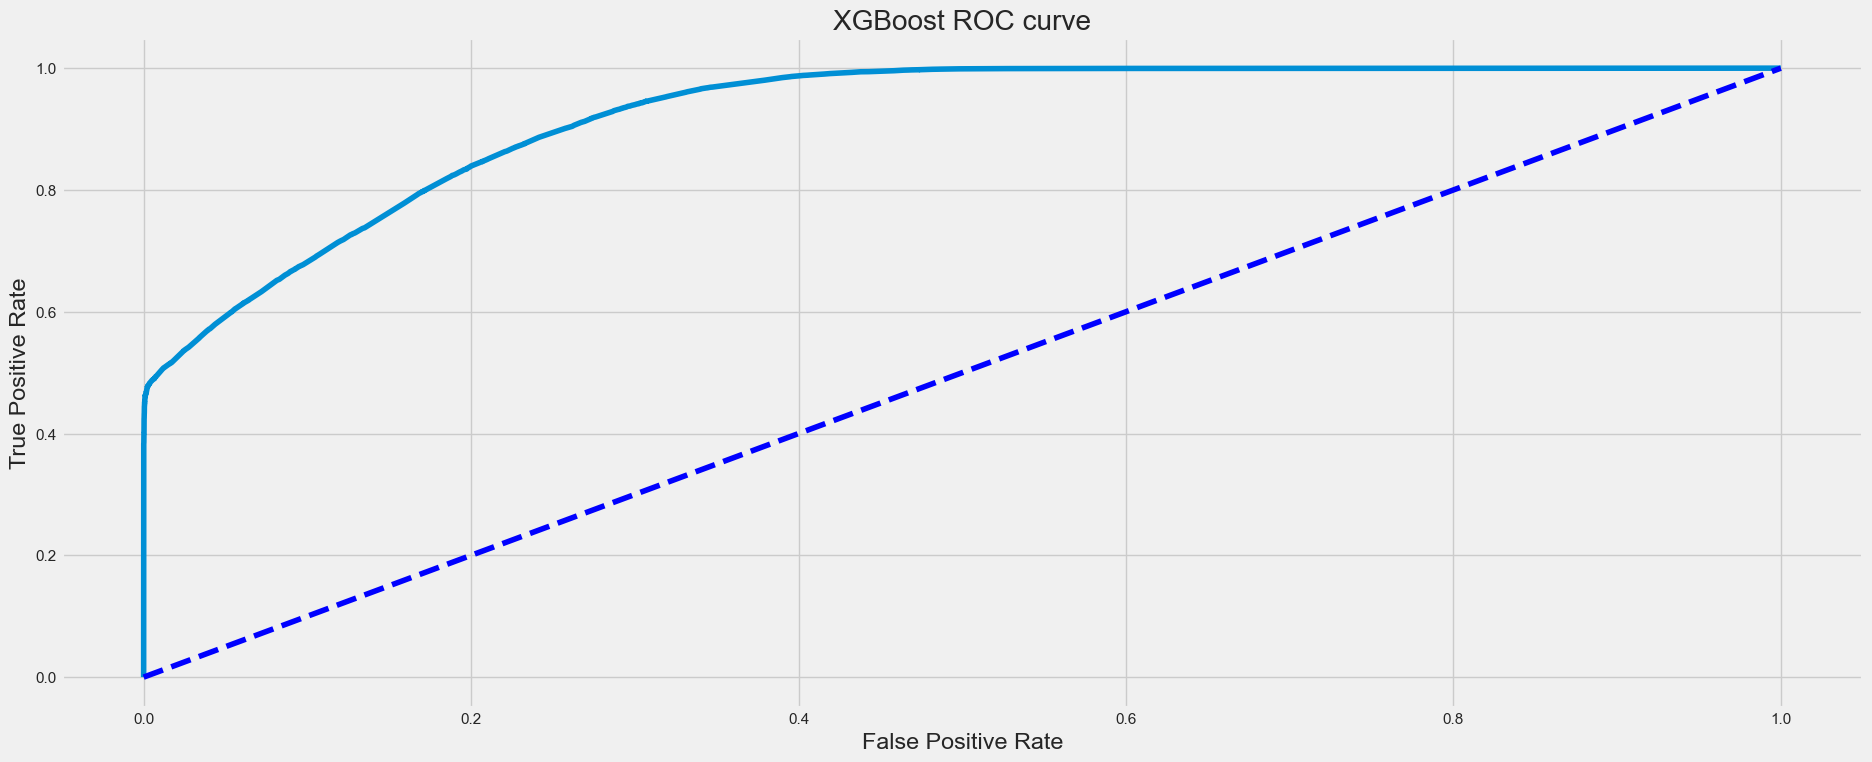

In [199]:
falposr, truposr, _ = roc_curve(y_test, y_pred_xg_prob)
plt.title('XGBoost ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[24357  8891]
 [ 2986 30646]]



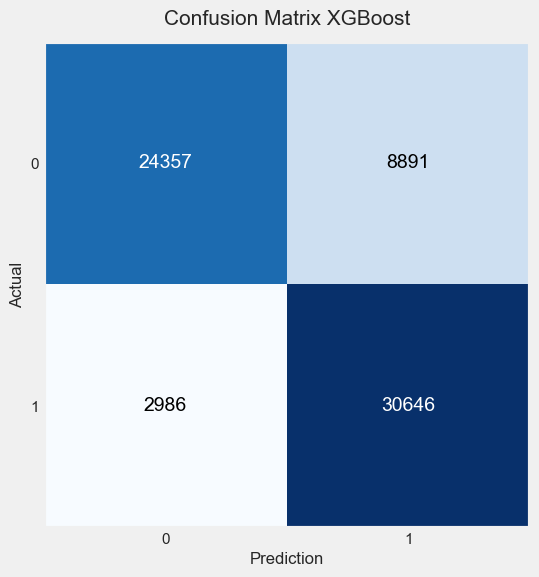

In [200]:
cmxg = confusion_matrix(y_test, y_pred_xg)
print(cmxg)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmxg, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix XGBoost', fontsize=15, pad=12)
plt.show()

### 5. Random Forest

In [201]:
rfmodel = rf.fit(X_train, y_train)
eval_classification(rfmodel)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.83
Precision (Test Set): 0.78
Precision (Train Set): 0.79
Recall (Test Set): 0.89
Recall (Train Set): 0.90
F1-Score (Test Set): 0.83
F1-Score (Train Set): 0.84
roc_auc (test-proba): 0.92
roc_auc (train-proba): 0.93
roc_auc (crossval train): 0.9250780541482652
roc_auc (crossval test): 0.9157550252356261


In [202]:
y_pred_rf_prob = rfmodel.predict_proba(X_test)[:,1]
y_pred_rf = rfmodel.predict(X_test)

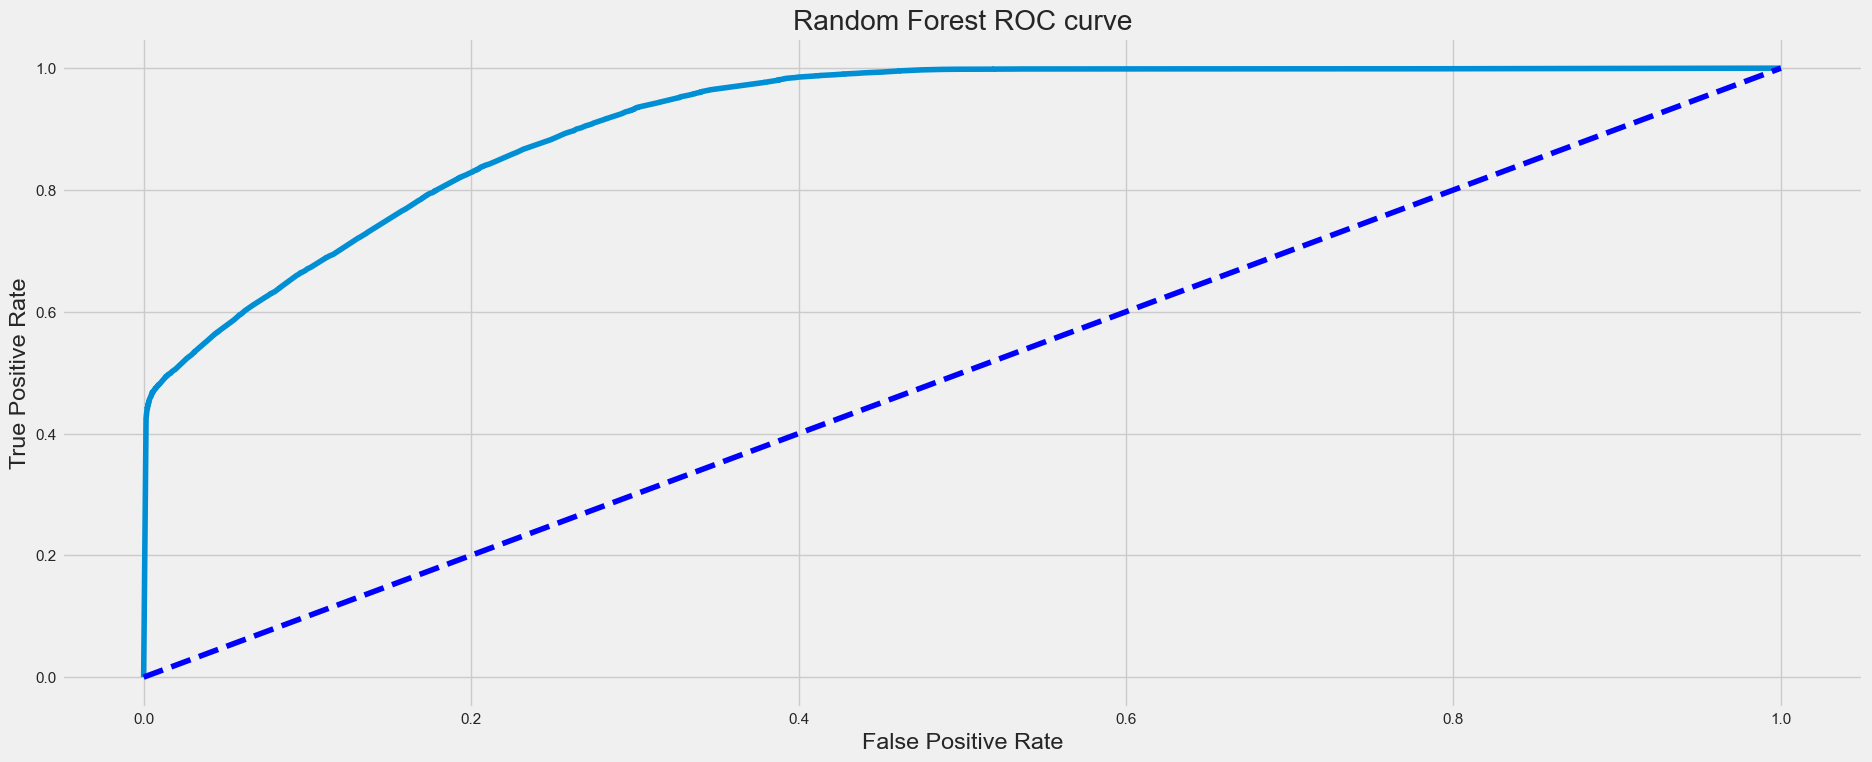

In [203]:
falposr, truposr, _ = roc_curve(y_test, y_pred_rf_prob)
plt.title('Random Forest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[24635  8613]
 [ 3555 30077]]



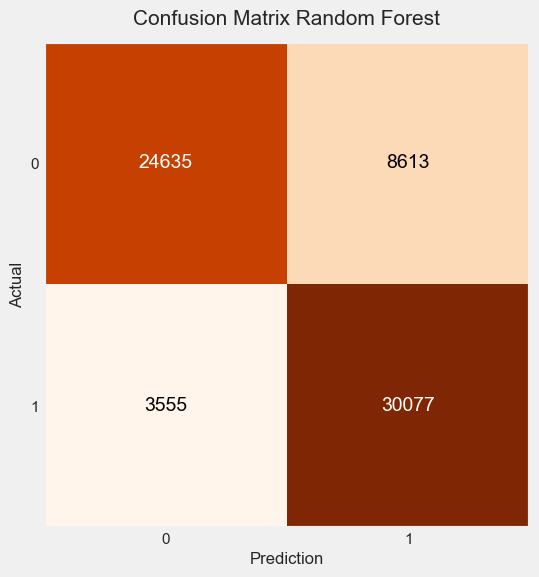

In [204]:
cmrf = confusion_matrix(y_test, y_pred_rf)
print(cmrf)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmrf, figsize=(6, 6), cmap=plt.cm.Oranges)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Random Forest', fontsize=15, pad=12)
plt.show()

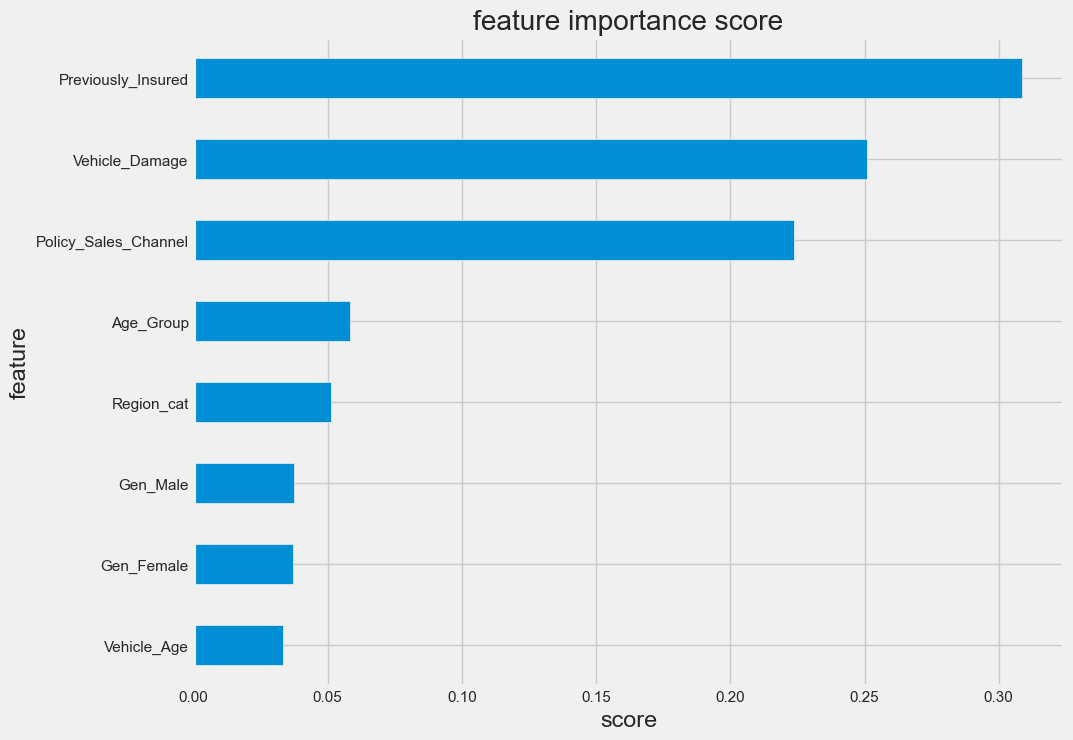

In [205]:
show_feature_importance(rfmodel)

### 6. LightGBM

In [206]:
lgbmodel = lgb.fit(X_train, y_train)
print('')
eval_classification(lgbmodel)

[LightGBM] [Info] Number of positive: 66687, number of negative: 67071
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 133758, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498565 -> initscore=-0.005742
[LightGBM] [Info] Start training from score -0.005742

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.82
Precision (Test Set): 0.77
Precision (Train Set): 0.77
Recall (Test Set): 0.91
Recall (Train Set): 0.91
F1-Score (Test Set): 0.84
F1-Score (Train Set): 0.84
roc_auc (test-proba): 0.92
roc_auc (train-proba): 0.92
roc_auc (crossval train): 0.9250819177830273
roc_auc (crossval test): 0.9158283379824589


In [207]:
y_pred_lgb_prob = lgbmodel.predict_proba(X_test)[:,1]
y_pred_lgb = lgbmodel.predict(X_test)

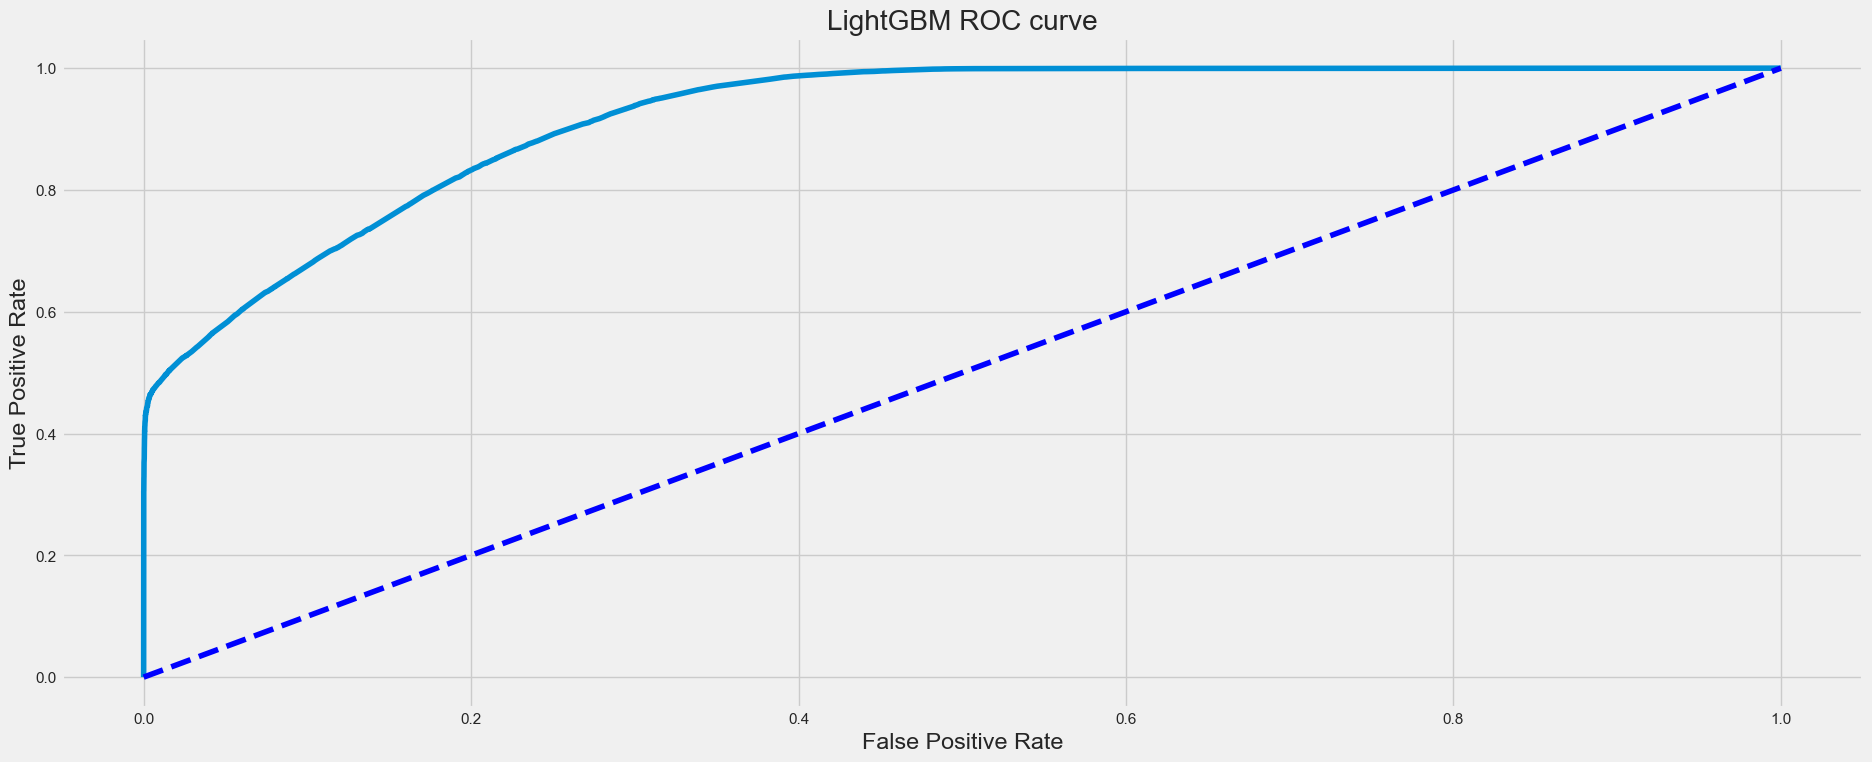

In [208]:
falposr, truposr, _ = roc_curve(y_test, y_pred_lgb_prob)
plt.title('LightGBM ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[24221  9027]
 [ 3015 30617]]



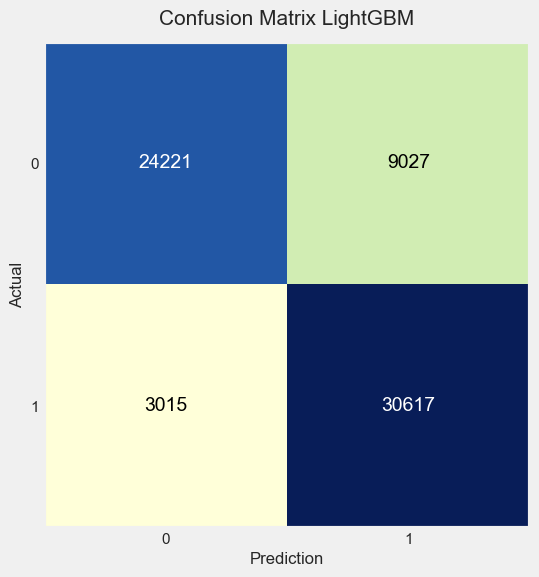

In [209]:
cmlgb = confusion_matrix(y_test, y_pred_lgb)
print(cmlgb)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmlgb, figsize=(6, 6), cmap=plt.cm.YlGnBu)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix LightGBM', fontsize=15, pad=12)
plt.show()

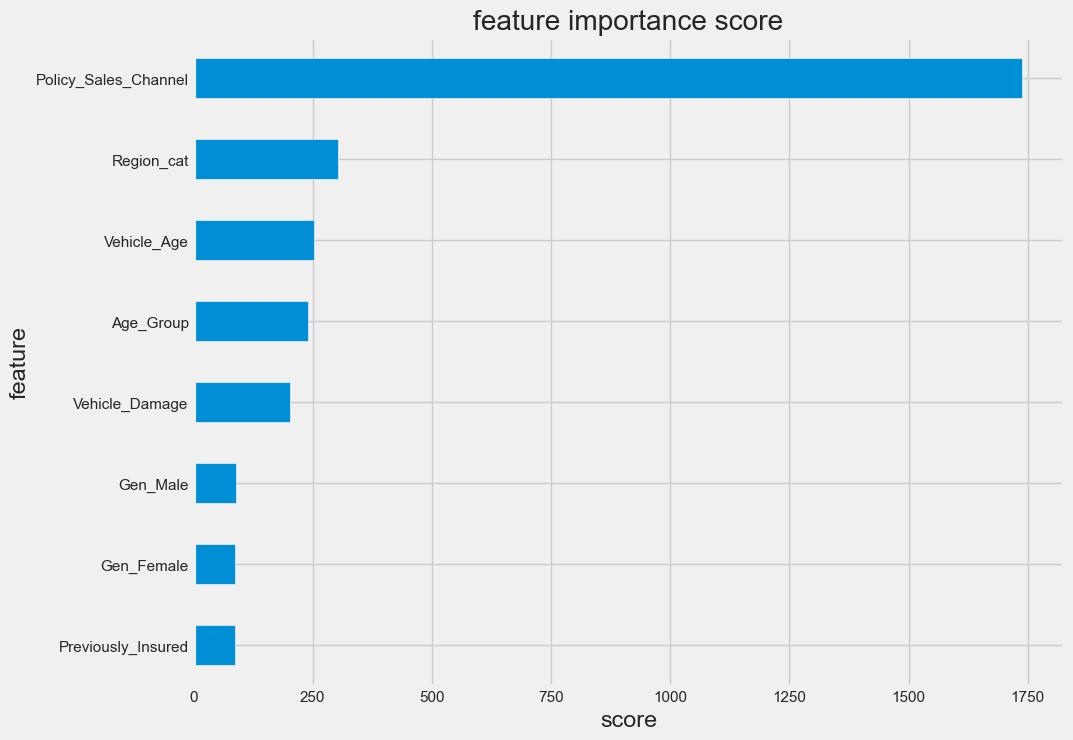

In [210]:
show_feature_importance(lgbmodel)

### 7. Gradient Boost

In [211]:
grdmodel = grd.fit(X_train, y_train)
eval_classification(grdmodel)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.82
Precision (Test Set): 0.76
Precision (Train Set): 0.76
Recall (Test Set): 0.93
Recall (Train Set): 0.92
F1-Score (Test Set): 0.84
F1-Score (Train Set): 0.84
roc_auc (test-proba): 0.91
roc_auc (train-proba): 0.91
roc_auc (crossval train): 0.9250739409598092
roc_auc (crossval test): 0.9157336694788446


In [213]:
y_pred_grd_prob = grdmodel.predict_proba(X_test)[:,1]
y_pred_grd = grdmodel.predict(X_test)

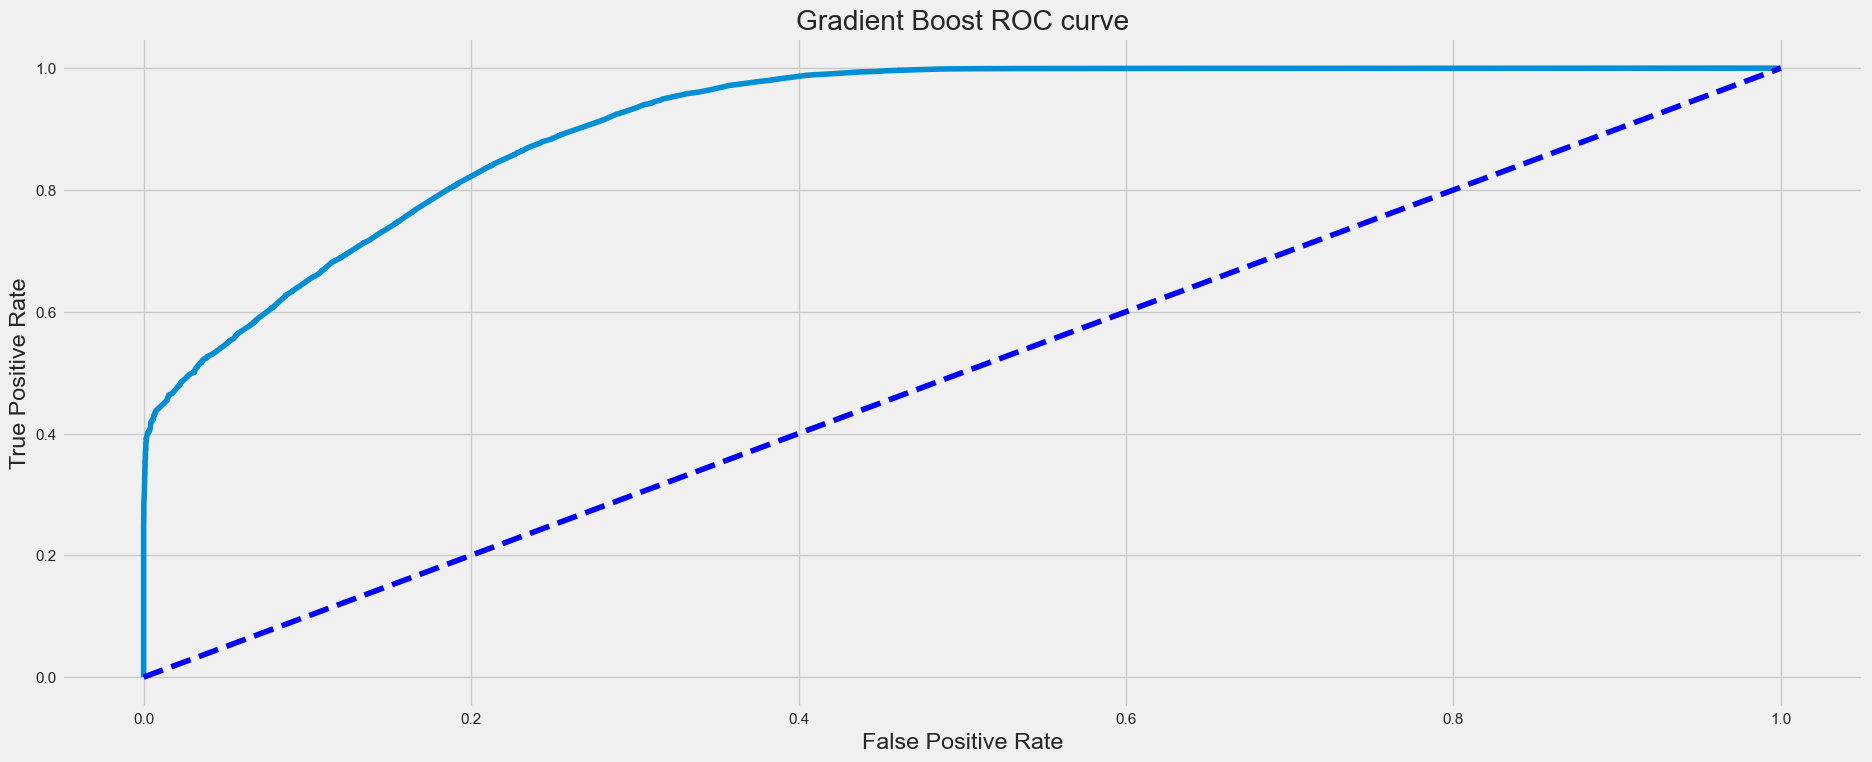

In [214]:
falposr, truposr, _ = roc_curve(y_test, y_pred_grd_prob)
plt.title('Gradient Boost ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(falposr, truposr)
plt.plot((0,1), linestyle='--',color='blue')
plt.show()

[[23550  9698]
 [ 2458 31174]]



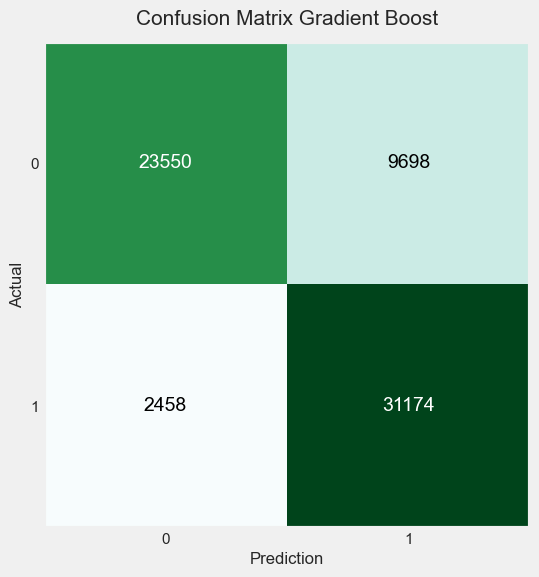

In [215]:
cmgrd = confusion_matrix(y_test, y_pred_grd)
print(cmgrd)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmgrd, figsize=(6, 6), cmap=plt.cm.BuGn)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Gradient Boost', fontsize=15, pad=12)
plt.show()

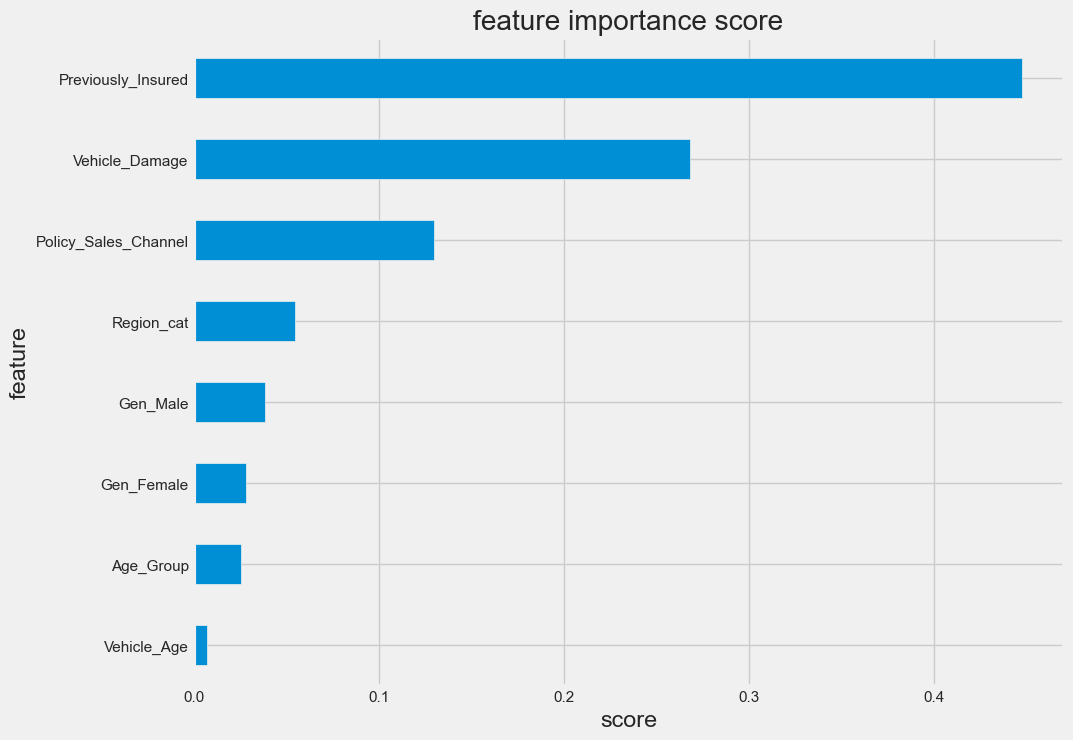

In [216]:
show_feature_importance(grdmodel)

## Hyperparameter Tuning

### 1. Logistic Regression

In [35]:
parameter = {'C': [float(x) for x in np.linspace(0.0001, 0.05, 100)],'penalty':['l2','l1', 'elasticnet']}
lgmodel2 = GridSearchCV(lg, parameter, cv = 3, n_jobs = -1 , verbose = 1, scoring = 'recall')
lgmodel2.fit(X_train, y_train)
lgmodelbest = lgmodel2.best_estimator_
y_pred_lg2 = lgmodelbest.predict(X_test)
y_pred_lg2_prob= lgmodelbest.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 300 candidates, totalling 900 fits


In [218]:
eval_classification(lgmodelbest)

Accuracy (Test Set): 0.78
Accuracy (Train Set): 0.79
Precision (Test Set): 0.71
Precision (Train Set): 0.71
Recall (Test Set): 0.96
Recall (Train Set): 0.95
F1-Score (Test Set): 0.82
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.87
roc_auc (train-proba): 0.87
roc_auc (crossval train): 0.9250729078020313
roc_auc (crossval test): 0.9157778526932893


In [219]:
show_best_hyperparameter(lgmodel2)

{'C': 0.01874949494949495, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### 2. Decision Tree

In [36]:
parameter = {
            'max_depth':[int(x) for x in np.linspace(1, 110, num = 30)],
            'min_samples_split':[2, 5, 10, 100], 
            'max_features':['auto', 'sqrt'],
            'criterion':['gini','entropy'],
            'splitter':['best','random']}

dtmodel2 = GridSearchCV(dt, parameter, cv=3, n_jobs = -1 , verbose = 1, scoring='recall')
dtmodel2.fit(X_train, y_train)
dtmodelbest = dtmodel2.best_estimator_
y_pred_dt2 = dtmodelbest.predict(X_test)
y_pred_dt2_prob= dtmodelbest.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


In [225]:
eval_classification(dtmodelbest)

Accuracy (Test Set): 0.79
Accuracy (Train Set): 0.79
Precision (Test Set): 0.73
Precision (Train Set): 0.72
Recall (Test Set): 0.94
Recall (Train Set): 0.94
F1-Score (Test Set): 0.82
F1-Score (Train Set): 0.82
roc_auc (test-proba): 0.86
roc_auc (train-proba): 0.86
roc_auc (crossval train): 0.9250746030016751
roc_auc (crossval test): 0.9157088511620103


In [226]:
show_best_hyperparameter(dtmodel2)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'random'}


### 3. XGBoost

In [37]:
parameter = {
            'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
            'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
            'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
            'tree_method' : ['auto', 'exact', 'approx', 'hist'],
            'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
            'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],
            'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
            'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
            }

xgmodel2 = RandomizedSearchCV(xgb, parameter, cv=3, n_jobs = -1 , verbose = 1, scoring='recall', random_state=42)
xgmodel2.fit(X_train,y_train)
xgmodelbest = xgmodel2.best_estimator_
y_pred_xg2 = xgmodelbest.predict(X_test)
y_pred_xg2_prob= xgmodelbest.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [40]:
eval_classification(xgmodelbest)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.82
Precision (Test Set): 0.76
Precision (Train Set): 0.76
Recall (Test Set): 0.94
Recall (Train Set): 0.94
F1-Score (Test Set): 0.84
F1-Score (Train Set): 0.84
roc_auc (test-proba): 0.92
roc_auc (train-proba): 0.92
roc_auc (crossval train): 0.9250774295472468
roc_auc (crossval test): 0.9157157232673333


In [43]:
show_best_hyperparameter(xgmodel2)

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.8, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 70, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'auto', 'validate_parameters': None, 'verbosity': None, 'lambda': 0.8, 'eta': 0.020202020202020204, 'alpha': 0.6000000000000001}


### 4. Random Forest

In [38]:
n_estimators = [int(x) for x in np.linspace(1, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_split = [int(x) for x in np.linspace(2, 20, 10)]
min_samples_leaf = [int(x) for x in np.linspace(2, 20, 10)]
parameter = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rsmodel2 = RandomizedSearchCV(rf, parameter, cv=3, n_jobs = -1 , verbose = 1, scoring='recall', random_state=42)
rsmodel2.fit(X_train,y_train)
rsmodelbest = rsmodel2.best_estimator_
y_pred_rs2 = rsmodelbest.predict(X_test)
y_pred_rs2_prob= rsmodelbest.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [45]:
eval_classification(rsmodelbest)

Accuracy (Test Set): 0.81
Accuracy (Train Set): 0.81
Precision (Test Set): 0.74
Precision (Train Set): 0.74
Recall (Test Set): 0.95
Recall (Train Set): 0.95
F1-Score (Test Set): 0.83
F1-Score (Train Set): 0.83
roc_auc (test-proba): 0.89
roc_auc (train-proba): 0.89
roc_auc (crossval train): 0.9250814209730314
roc_auc (crossval test): 0.9157813696553474


In [44]:
show_best_hyperparameter(rsmodel2)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 18, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 114, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### 5. LightGBM

In [39]:
f2 = make_scorer(fbeta_score, beta =2)
parameter = {"n_estimators":[200,300,400],"max_depth":[3,5,9]}
lgbmodel2 = HalvingGridSearchCV(lgb, parameter, scoring = f2, cv=3, n_jobs = -1, verbose = 1)
lgbmodel2.fit(X_train,y_train)
lgbmodel2.best_params_, lgbmodel2.best_score_
lgbmodelbest = LGBMClassifier(**lgbmodel2.best_params_)
lgbmodelbest.fit(X_train, y_train)
y_pred_lgb2 = lgbmodelbest.predict(X_test)
y_pred_lgb2_prob = lgbmodelbest.predict_proba(X_test)[:,1]

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 14862
max_resources_: 133758
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 14862
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 3
n_resources: 44586
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 2
n_candidates: 1
n_resources: 133758
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Number of positive: 66687, number of negative: 67071
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 133758, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498565 -> initscore=-0.005742
[L

In [47]:
eval_classification(lgbmodelbest)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.82
Precision (Test Set): 0.77
Precision (Train Set): 0.77
Recall (Test Set): 0.92
Recall (Train Set): 0.92
F1-Score (Test Set): 0.84
F1-Score (Train Set): 0.84
roc_auc (test-proba): 0.92
roc_auc (train-proba): 0.92
roc_auc (crossval train): 0.9250770200136378
roc_auc (crossval test): 0.9157338990812915


In [138]:
show_best_hyperparameter(lgbmodel2)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


### 6. Gradient Boost

In [66]:
parameter = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750], 'max_depth':[3,4,5,6,7,8], 'min_samples_split':[2,3,4,5],'min_samples_leaf':[1,2],'max_features':['sqrt','auto']}

grdmodel2 = RandomizedSearchCV(grd, parameter, scoring='recall', n_jobs=-1, cv=3, verbose=1)
grdmodel2.fit(X_train,y_train)
grdmodel2.best_params_, grdmodel2.best_score_
grdmodelbest = GradientBoostingClassifier(**grdmodel2.best_params_)
grdmodelbest.fit(X_train, y_train)
y_pred_grd2 = grdmodelbest.predict(X_test)
y_pred_grd2_prob = grdmodelbest.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [67]:
eval_classification(grdmodelbest)

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.82
Precision (Test Set): 0.76
Precision (Train Set): 0.76
Recall (Test Set): 0.93
Recall (Train Set): 0.93
F1-Score (Test Set): 0.84
F1-Score (Train Set): 0.83
roc_auc (test-proba): 0.91
roc_auc (train-proba): 0.91
roc_auc (crossval train): 0.9250743577573847
roc_auc (crossval test): 0.9157536867018333


In [68]:
show_best_hyperparameter(grdmodel2)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.15, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


# Conclusion

### Hasil Score Modelling

|Model|Accuracy Test|Accuracy Train|Precision Test|Precision Train|Recall Test|Recall Train|F1 Test|F1 Train|ROC AUC Test|ROC AUC Train|ROC AUC CrossVal Test|ROC AUC CrossVal Train|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Logistic|0.79|0.79|0.72|0.72|0.93|0.94|0.82|0.82|0.87|0.87|0.93|0.92|
|KNN|0.79|0.80|0.78|0.78|0.83|0.83|0.80|0.80|0.89|0.89|0.93|0.92|
|Decision Tree|0.82|0.83|0.78|0.79|0.89|0.90|0.83|0.84|0.91|0.93|0.93|0.92|
|XGBoost|0.82|0.83|0.78|0.78|0.91|0.91|0.84|0.84|0.92|0.92|0.93|0.92|
|Random Forest|0.82|0.83|0.78|0.79|0.89|0.90|0.83|0.84|0.92|0.93|0.93|0.92|
|LightGBM|0.82|0.82|0.77|0.77|0.91|0.91|0.84|0.84|0.92|0.92|0.93|0.92|
|Gradient Boost|0.82|0.82|0.76|0.76|0.93|0.92|0.84|0.84|0.91|0.91|0.93|0.92|

### Hasil Score Setelah Hyperparameter Tuning

|Model|Accuracy Test|Accuracy Train|Precision Test|Precision Train|Recall Test|Recall Train|F1 Test|F1 Train|ROC AUC Test|ROC AUC Train|ROC AUC CrossVal Test|ROC AUC CrossVal Train|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Logistic|0.78|0.79|0.71|0.71|0.96|0.95|0.82|0.82|0.87|0.87|0.93|0.92|
|Decision Tree|0.79|0.79|0.73|0.72|0.94|0.94|0.82|0.82|0.86|0.86|0.93|0.92|
|XGBoost|0.82|0.82|0.76|0.76|0.94|0.94|0.84|0.84|0.92|0.92|0.93|0.92|
|Random Forest|0.81|0.81|0.74|0.74|0.95|0.95|0.83|0.83|0.89|0.89|0.93|0.92|
|LightGBM|0.82|0.82|0.77|0.77|0.92|0.92|0.84|0.84|0.92|0.92|0.93|0.92|
|Gradient Boost|0.82|0.82|0.76|0.76|0.93|0.93|0.84|0.83|0.91|0.91|0.93|0.92|

Dari karakteristik dataset yang sudah tidak memiliki *class imbalance* serta tujuan bisnis, evaluasi akan menitik beratkan pada score ***recall*** dimana meminimalisir False Negative serta ***ROC AUC*** score untuk menilai sejauh mana model mampu membedakan kelas (TPR dan FPR) walaupun *class* sudah seimbang.

Dari score diatas didapatkan model yang memiliki score yang baik untuk prediksi klasifikasi adalah model hasil algoritma `XGBoost`, `LightGBM`, `Random Forest` dan `Gradient Boost`.

### XGBoost dan Features Importance

[[23290  9958]
 [ 2146 31486]]



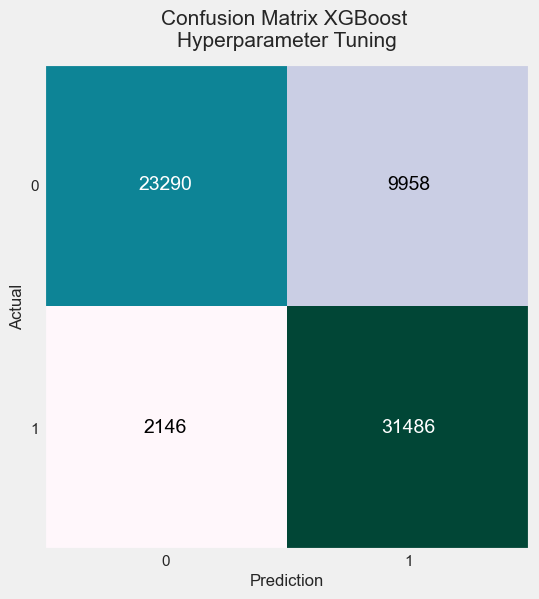

In [81]:
cmxg2 = confusion_matrix(y_test, y_pred_xg2)
print(cmxg2)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmxg2, figsize=(6, 6), cmap=plt.cm.PuBuGn)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix XGBoost \nHyperparameter Tuning', fontsize=15, pad=12)
plt.show()

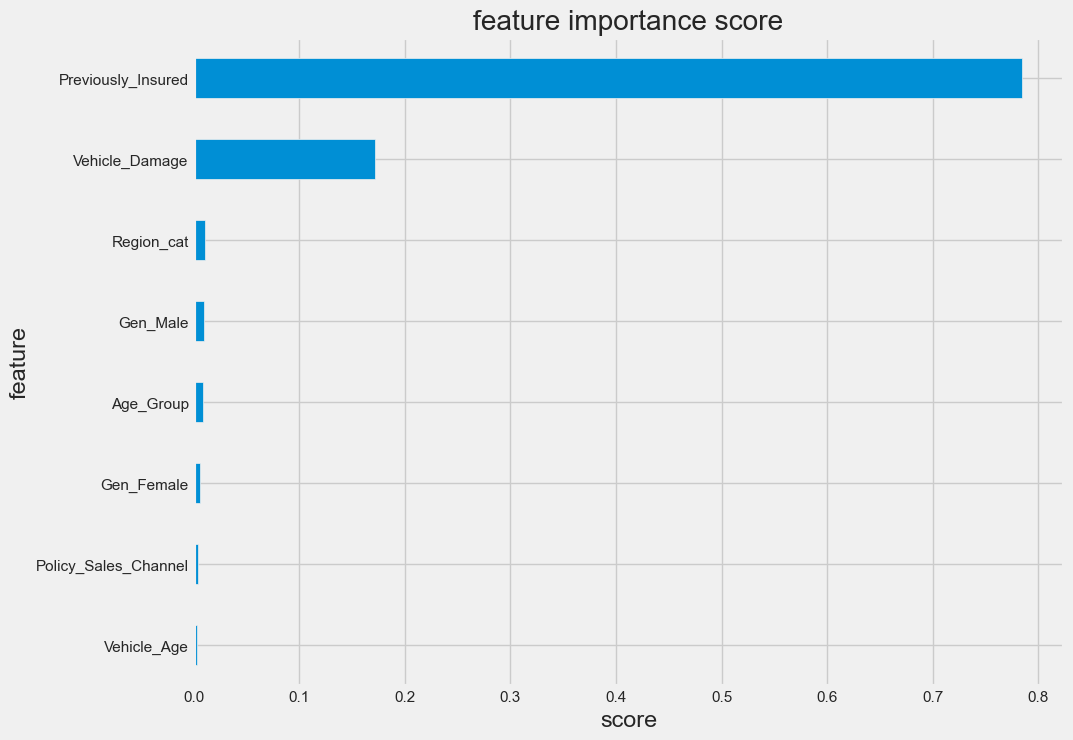

In [75]:
show_feature_importance(xgmodelbest)

Pada model **`XGBoost`**, 2 *features* yang memiliki *importance* terbesar adalah `Previously_Insured` dan `Vehicle_Damage` sedangkan 2 *features* yang paling rendah adalah `Policy_Sales_Channel` dan `Vehicle_Age`.

### LightGBM dan Features Impotance

[[23936  9312]
 [ 2740 30892]]



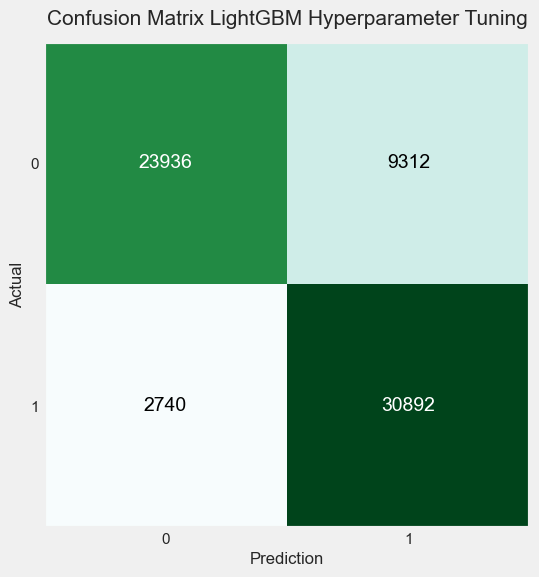

In [49]:
cmlgb2 = confusion_matrix(y_test, y_pred_lgb2)
print(cmlgb2)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmlgb2, figsize=(6, 6), cmap=plt.cm.BuGn)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix LightGBM Hyperparameter Tuning', fontsize=15, pad=12)
plt.show()

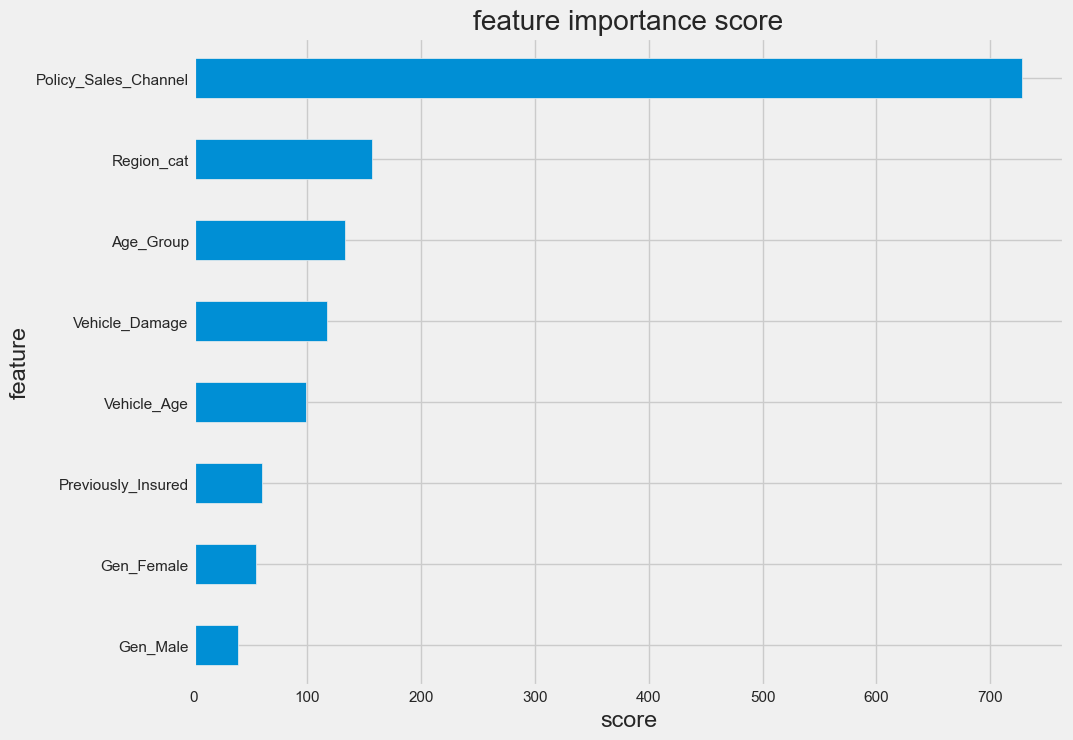

In [76]:
show_feature_importance(lgbmodelbest)

Pada model **`LightGBM`** hampir seluruh *features* terlihat memiliki *importance* yang cukup tinggi dibandingkan model XGBoost, dimana `Policy_Sales_Channel` dan `Region_cat` memiliki *importance* yang tertinggi serta `Gen_Female` dan `Gen_Male` memiliki *importance* yang rendah.

### Random Forest dan Features Importance

[[22023 11225]
 [ 1742 31890]]



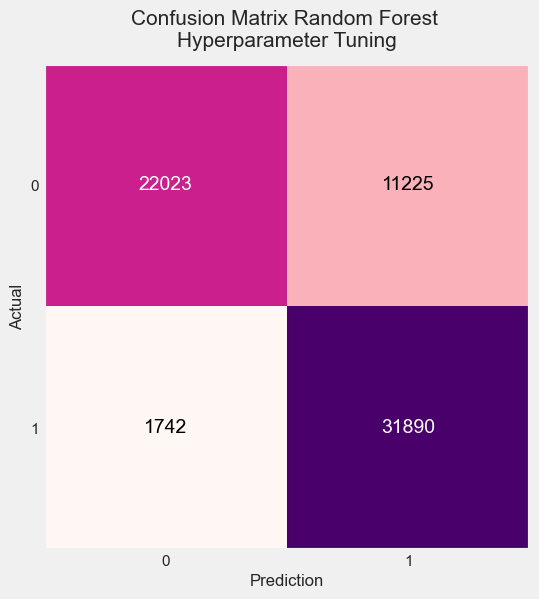

In [54]:
cmrf2 = confusion_matrix(y_test, y_pred_rs2)
print(cmrf2)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmrf2, figsize=(6, 6), cmap=plt.cm.RdPu)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Random Forest \nHyperparameter Tuning', fontsize=15, pad=12)
plt.show()

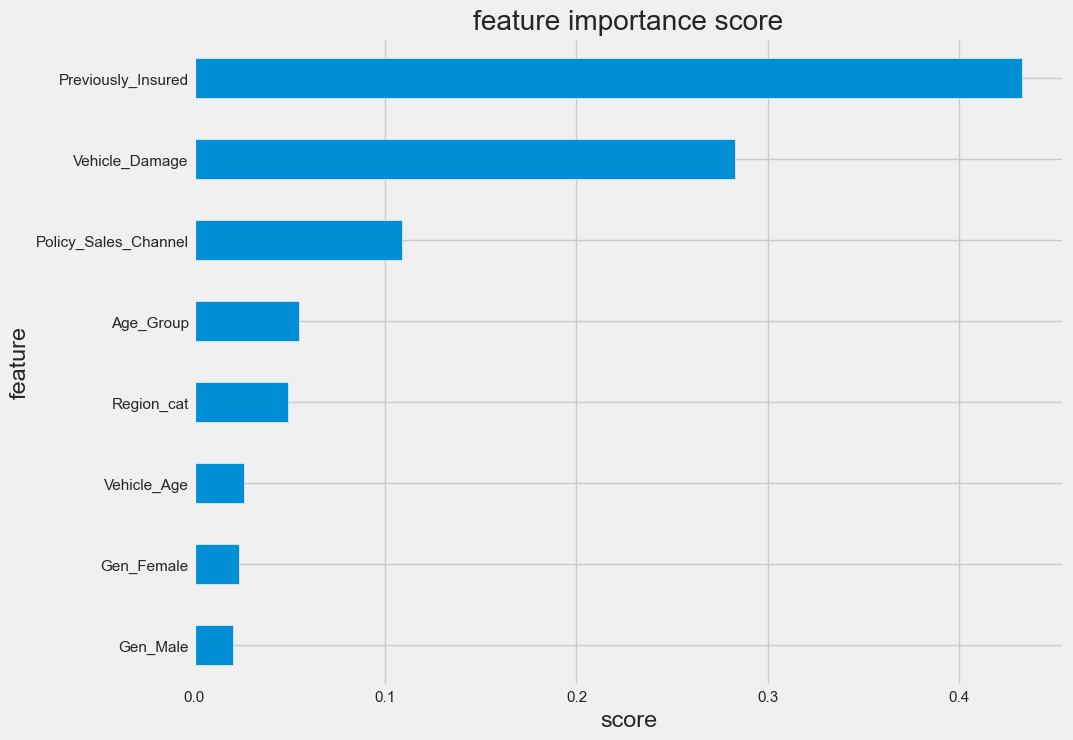

In [77]:
show_feature_importance(rsmodelbest)

Sama layaknya LightGBM, pada model **`Random Forest`** hampir tidak *features* memiliki *importance* yang signifikan, dimana sama dengan XGBoost *features* tertinggi nya adalah `Previously_Insured` dan `Vehicle_Damage` namun *features* terendahnya sama dengan LightGBM `Gen_Female` dan `Gen_Male`.

### Gradient Boost dan Features Importance

[[23363  9885]
 [ 2423 31209]]



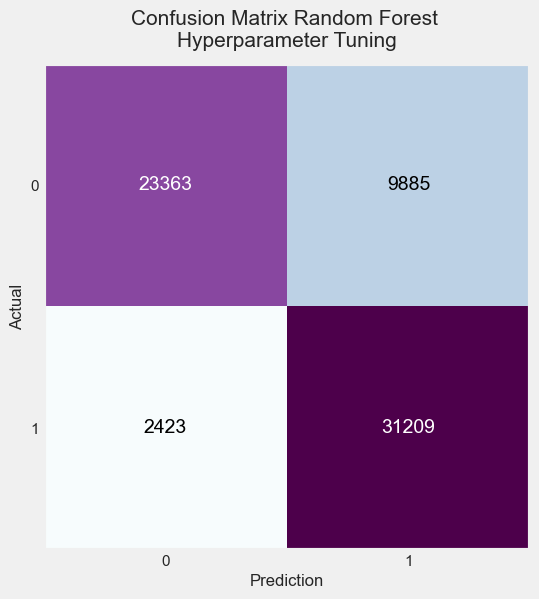

In [73]:
cmgrd2 = confusion_matrix(y_test, y_pred_grd2)
print(cmgrd2)
print('')
fig, ax = plot_confusion_matrix(conf_mat=cmgrd2, figsize=(6, 6), cmap=plt.cm.BuPu)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Random Forest \nHyperparameter Tuning', fontsize=15, pad=12)
plt.show()

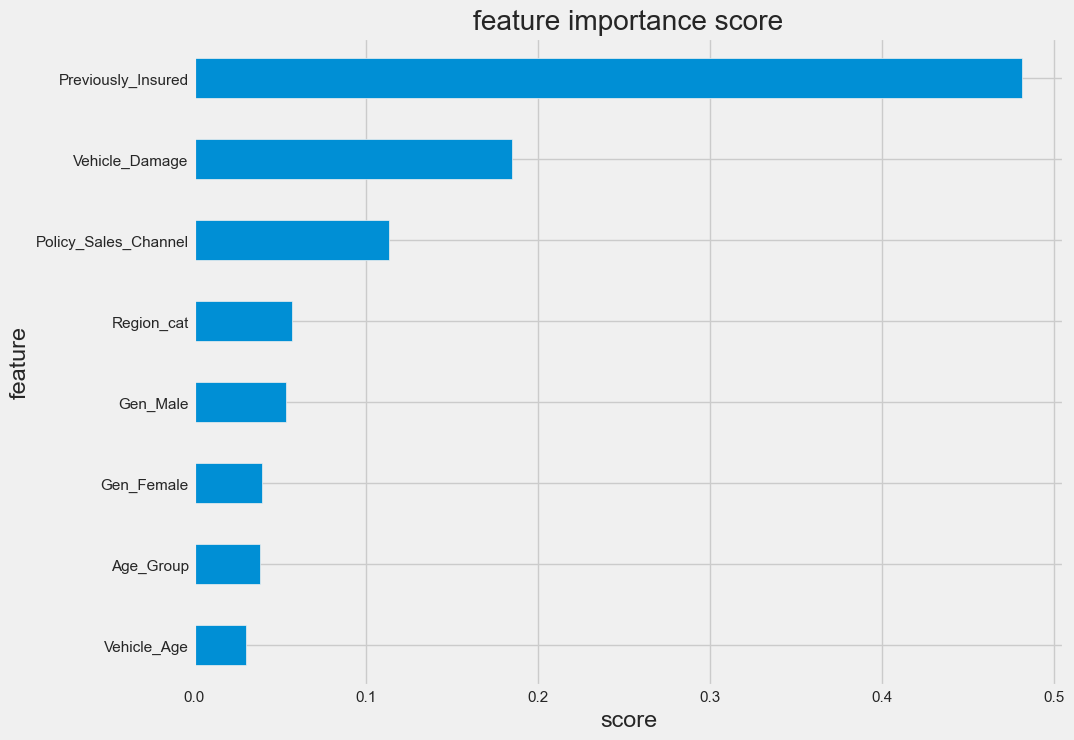

In [78]:
show_feature_importance(grdmodelbest)

Sama dengan Random Forest dan XGBoost, *features* **`Gradient Boost`** yang tertinggi adalah `Previously_Insured` dan `Vehicle_Damage` sedangkan 2 features terendah adalah `Age_Group` dan `Vehicle_Age`.

## The Best Fit Model

### **`XGBoost Model`**

Model ini memiliki score recall yang tinggi yakni mencapai **0.94** dengan probabilitas machine learning sebesar **0.92** dan AUC ROC mencapai **0.91** pada hasil test data. Sedangkan pada train data nya hanya memiliki selisih terbesar 0.02 dari test data, yakni model tidak overfit maupun underfit yang dapat disebut sebagai model ***best fit***.

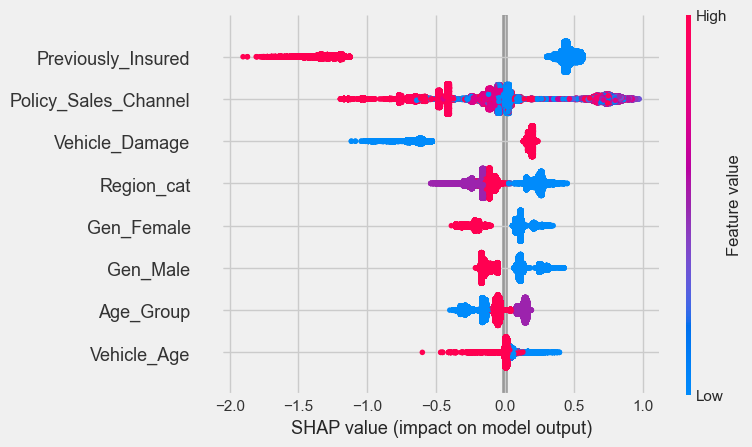

In [83]:
# Melihat shap value tiap features
explainer = shap.TreeExplainer(xgmodelbest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

* `'Previously_Insured'`: Value yang bernilai tinggi memiliki kontribusi negatif dengan hasil prediksi sedangkan value yang nilainya rendah memiliki kontribusi positif terhadap hasil prediksi.
* `'Policy_Sales_Channel'`: Semakin tinggi value berdampak kontribusi negatif terhadap prediksi sedangkan semakin rendah value memiliki kontribusi positif terhadap hasil prediksi.
* `'Vehicle_Damage'`: Semakin value bernilai tinggi memiliki kontribusi positif terhadap prediksi dan semakin rendah nilai value memiliki kontibusi negatif terhadap prediksi.
* `'Region_cat'`: Value yang bernilai tengah ke tinggi memiliki kontribusi negatif terhadap prediksi dan sebaliknya value yang bernilai rendah memiliki kontribusi yang positif.
* `'Gen_Female'`: Value tinggi berkontribusi negatif dan value rendah berkontribusi positif.
* `'Gen_Male'`: Value tinggi berkontribusi negatif dan value rendah berkontribusi positif.
* `'Age_Group'`: Value yang bernilai rendah dan tinggi memiliki kontibusi yang negatif terhadap prediksi sedangkan value yang memiliki nilai ditengah-tengah memiliki kontribusi yang positif.
* `'Vehicle_Age'`: Semakin tinggi value semakin negatif kontribusinya, dan semakin rendah value semakin positif kontribusinya terhadap prediksi.

In [89]:
import pickle
pickle.dump(xgmodelbest, open('XGBoost_Model.pkl', 'wb'))